# General settings and loading of files

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

from IPython.display import display, Math, Latex
from matplotlib import cm

% matplotlib inline
% load_ext autoreload
% autoreload 2

pd.options.display.max_columns = 40  # Affy csv has 30 fields
# pd.options.display.mpl_style = 'default' # Old version of matplotlib
# mpl.style.use('default')

mpl.rc('figure', figsize=(13, 7), facecolor="white")
mpl.rc('axes', titlesize=17, labelsize=14)
mpl.rc('xtick', labelsize=11)
mpl.rc('ytick', labelsize=11)
mpl.rc('font', family='serif')
mpl.rc('legend', fontsize=15)

In [2]:
%run helpers/data_munging_functions.py
%run helpers/number_helpers.py

In [3]:
%run discriminate_present_vs_missing.py

GALANTER_CSV = '~/tesina/galanter_SNPs.csv'
LAT1_CSV = '~/tesina/affy-LAT1/Axiom_GW_LAT.na35.annot.csv'  # 1.1Gb file!
# Smaller file for testing:
# LAT1_CSV_SMALL = "affy-LAT1/Axiom_GW_LAT.na35.annot.TRUNCATED.csv"

# lat = _create_Affymetrix_df(LAT1_CSV)

galanter, present, missing = discriminate_present_vs_missing(
    GALANTER_CSV, LAT1_CSV, dumpdir="dumpfiles")

In [4]:
print("{} Galanter AIMs".format(len(galanter)))
print("{} present in LAT".format(len(present)))
print("{} missing in LAT".format(len(missing)))

446 Galanter AIMs
180 present in LAT
266 missing in LAT


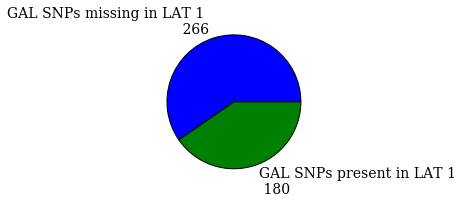

In [5]:
labels = [
    "GAL SNPs missing in LAT 1 \n %s" % len(missing),
    "GAL SNPs present in LAT 1 \n %s" % len(present)
]
snp_counts = pd.Series([len(missing), len(present)],
                       index=labels)


ax = snp_counts.plot('pie', figsize=(3,3), labeldistance=1.25, fontsize=14)
ax.set_ylabel("")
plt.show()

## Comparar Galanter.bed con Galanter de PLoS

In [6]:
galanter_updated = pd.read_csv("../galanter.bed", sep="\t", skiprows=1, 
                               names=['chr', 'pos', 'pos_to', 'id'],
                               usecols=['chr', 'pos', 'pos_to', 'id'])
galanter_updated['chr'] = galanter_updated['chr'].str.replace("chr", "").astype(int)
galanter_updated = galanter_updated.set_index('id')

In [7]:
galanter_plos = galanter[['chr', 'position']]

In [8]:
import re

galanter_dbSNP = pd.read_csv("../galanter_rsIDs_dbSNP", names=['id', 'source', 'chr', 'pos', 'pos_to'], skiprows=1).set_index('id')
take_these_out = galanter_dbSNP.chr.str.contains('HSCHR')
galanter_dbSNP = galanter_dbSNP[~take_these_out]
galanter_dbSNP['chr'] = galanter_dbSNP['chr'].astype(int)
galanter_dbSNP = galanter_dbSNP.drop_duplicates()

In [9]:
galanter_plos.index.difference(galanter_dbSNP.index)

Index(['rs5748014', 'rs8081410'], dtype='object')

In [10]:
galanter_dbSNP.index.difference(galanter_plos.index)

Index([], dtype='object')

In [11]:
comparison = galanter_plos.join(galanter_dbSNP, lsuffix='_PLOS')
diff_position = abs(comparison.position - comparison.pos) > 2
diff_chromosome = comparison.chr_PLOS - comparison.chr > 0
comparison.head()

,chr_PLOS,position,source,chr,pos,pos_to
SNP rsID,,,,,,
rs6685064,1,1201155,dbSNP,1,1275912,1275912
rs12085319,1,10952065,dbSNP,1,10969421,10969421
rs2745285,1,11549445,dbSNP,1,11566801,11566801
rs4920310,1,18436476,dbSNP,1,18237395,18237395
rs6684063,1,30471927,dbSNP,1,30226493,30226493


# I should be using info form HG last build! #FIXME
ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA_000001405.15_GRCh38/GCA_000001405.15_GRCh38_assembly_stats.txt

In [12]:
# Temporary. I'd better look for the numbers of the same build of the HG as in Galanter and HGP

HUMAN_GENOME = '/home/juan/tesina/human_genome.txt'  # Chromosome lenghts and centromeres
genome = pd.read_csv(HUMAN_GENOME, delimiter="\t")
centromere_info = genome['centromere'].apply(lambda e: pd.Series(e.split(',')).astype(int))
genome = genome.drop('centromere', axis=1)
genome = pd.concat([genome, centromere_info], axis=1)
genome = genome.set_index('ID')
genome.columns = ['length', 'centromere_start', 'centromere_end']
genome = genome.drop(['X', 'Y'])
genome.index = genome.index.rename('chr')
genome.index = genome.index.astype(int)  # This only works after removing X and Y

### Distancias entre los AIMs por cromosoma

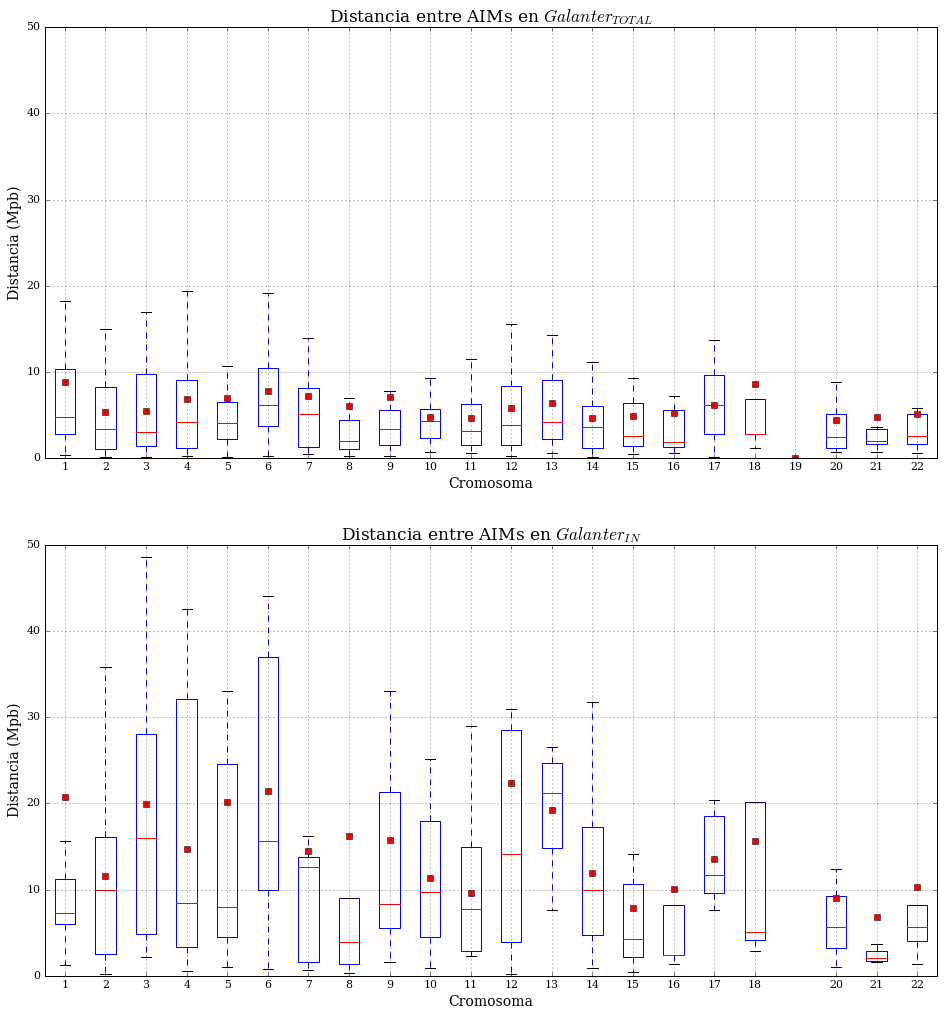

In [13]:
% run data_munging/distances.py
% run SNP_distances_plots.py

ax1 = plt.subplot(211)
ax1 = distances_boxplot(galanter, genome, ax=ax1, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{TOTAL}$")

ax2 = plt.subplot(212, sharey=ax1)
ax2 = distances_boxplot(present, genome, ax=ax2, showfliers=False, showmeans=True,
                        title=r"Distancia entre AIMs en $Galanter_{IN}$")

ax1.grid()
ax2.grid()

f = ax2.figure
f.set_figheight(17)
f.set_figwidth(16)

plt.show()

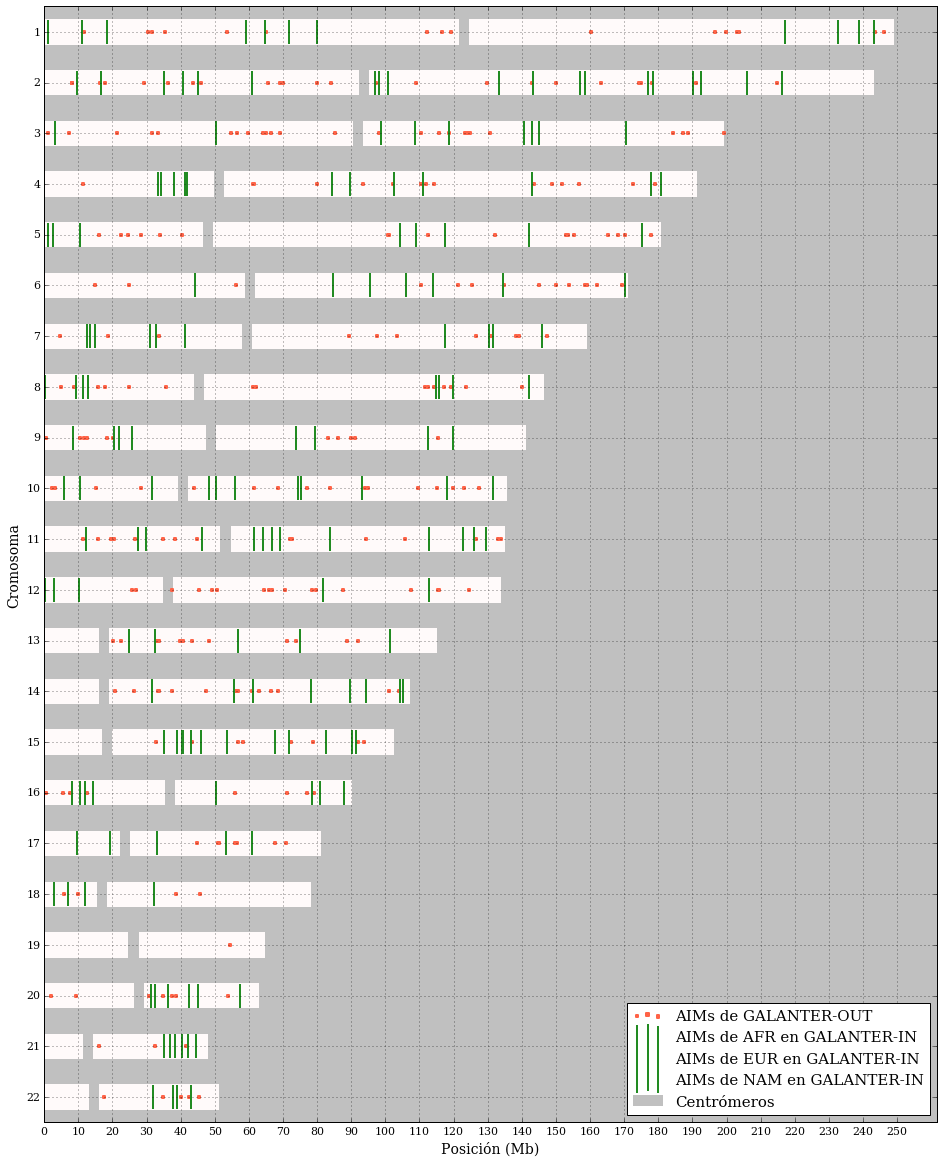

In [14]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
    ('AIMs de GALANTER-OUT',
     {'df': missing, 'marker': 's', 's': 7, 'color': 'tomato'}),
        
    ('AIMs de AFR en GALANTER-IN',
     {'df': present[present.population == "AFR"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
        
    ('AIMs de EUR en GALANTER-IN',
     {'df': present[present.population == "EUR"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
        
    ('AIMs de NAM en GALANTER-IN',
     {'df': present[present.population == "NAM"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
])

chromosomes_with_SNPs_plot(genome, plot_data)
plt.show()

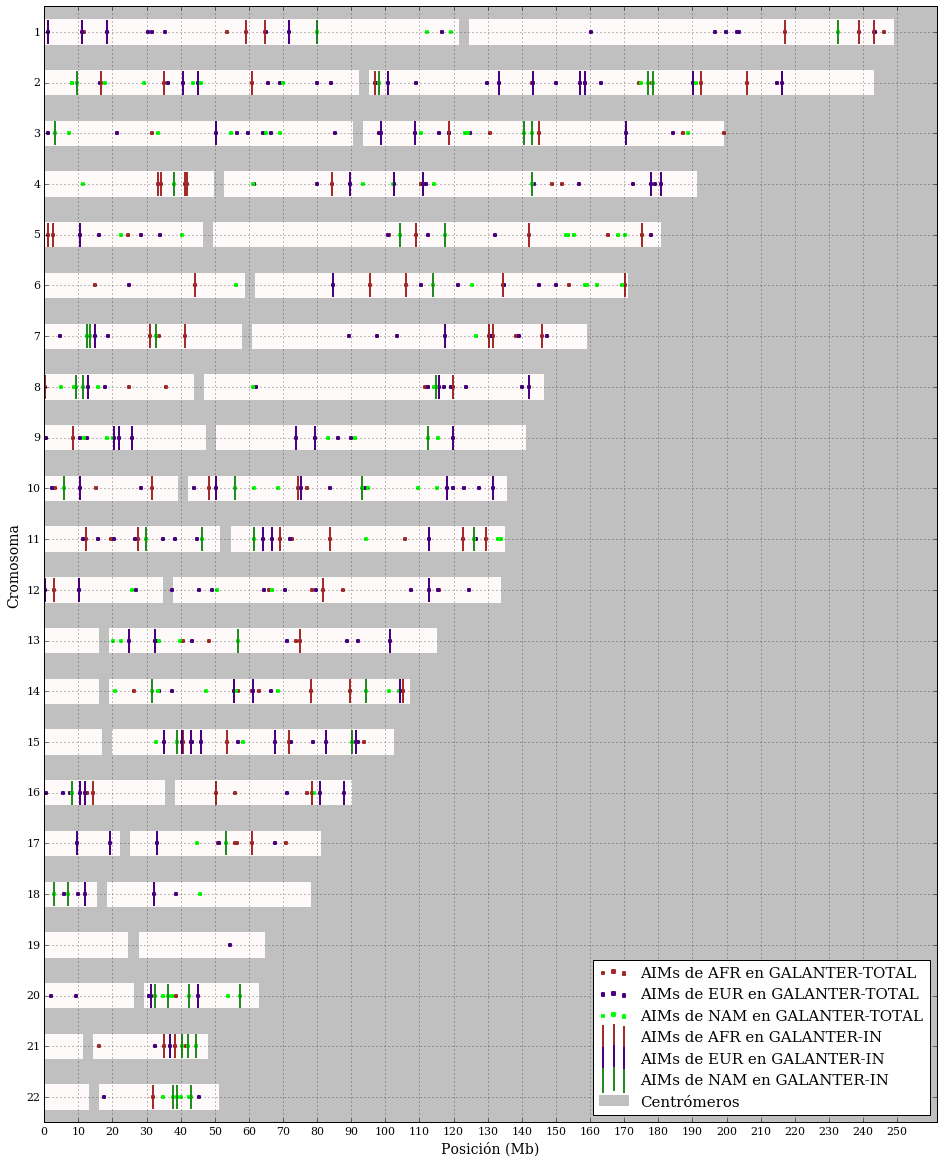

In [15]:
% run chromosomes_with_SNPs_plot.py

from collections import OrderedDict


plot_data = OrderedDict([
        
    ('AIMs de AFR en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "AFR"],
      'marker': 's', 'color': 'brown', 's': 7}),
        
    ('AIMs de EUR en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "EUR"],
      'marker': 's', 'color': 'indigo', 's': 7}),
        
    ('AIMs de NAM en GALANTER-TOTAL',
     {'df': galanter[galanter.population == "NAM"],
      'marker': 's', 'color': 'lime', 's': 7}),
        
    ('AIMs de AFR en GALANTER-IN',
     {'df': present[present.population == "AFR"],
      'marker': '|', 'color': 'brown', 's': 600}),
        
    ('AIMs de EUR en GALANTER-IN',
     {'df': present[present.population == "EUR"],
      'marker': '|', 'color': 'indigo', 's': 600}),
        
    ('AIMs de NAM en GALANTER-IN',
     {'df': present[present.population == "NAM"],
      'marker': '|', 'color': 'forestGreen', 's': 600}),
])

chromosomes_with_SNPs_plot(genome, plot_data)
plt.show()

In [16]:
def pop_counts(df):
    return df.groupby(['chr', 'population']).size().unstack().fillna('>> 0 <<')

df = pd.merge(pop_counts(galanter), pop_counts(present),
         left_index=True, right_index=True,
         suffixes=['_TOTAL', '_IN'])

df.columns = pd.MultiIndex.from_product([['$GALANTER_{TOTAL}$', '$GALANTER_{IN}$'],
                                         ['AFR', 'EUR', 'NAM']])
df

$GALANTER_{TOTAL}$         $GALANTER_{IN}$                  
                   AFR EUR NAM             AFR      EUR      NAM
chr                                                             
1                    8  15   4               5        4        2
2                   11  21  12               7        9        4
3                    7  16  12               2        4        3
4                    8  12   7               5        5        2
5                    8   8   9               5        1        2
6                    7   7   7               5        1        1
7                    7  10   4               5        2        3
8                    5  10   8               2        3        3
9                    1  11   7               1        6        1
10                   6  13   8               3        5        3
11                   9  12   7               6        3        4
12                   6  13   3               2        3  >> 0 <<
13                   4   8   5               1        3        1
14                   7   6   9               3        3        2
15                   4  12   4               3        7        2
16                   6   8   2               3        4        1
17                   5   5   2               1        3        1
18             >> 0 <<   5   3         >> 0 <<        2        2
20                   1   5   7         >> 0 <<        2        4
21                   4   2   3               2        1        3
22                   1   2   6               1  >> 0 <<        3

**DISCUSIÓN**

La reducción de AIMs en GALANTER-IN determina que ciertos cromosomas no tengan ningún AIM de una población determinada:

- En el cromosoma 12 se perdieron los 3 AIMs de NAM.
- En el cromosoma 20 se perdió el único AIM de AFR.
- En el cromosoma 22 se perdieron los 2 AIMs de EUR.

# Generate a CONTROL PANEL of random SNPs
Extract the **same amount** of SNPs per chromosome as Galanter has, with some min space between them.

In [17]:
galanter.groupby("chr").size().to_csv("data/chr_SNP_count_in_galanter")

In [18]:
# The script "./thin_N_SNPs_from_chromosome_Q.sh" randomlyt selects the SNPs using PLINK
# Then the results are merged with plink --merge-list

# Traer la data de 1000Genomes para estos SNPs

In [19]:
# %load /home/juan/tesina/1000genomes/ftp_download_1000_genomes.py

In [20]:
# % run extract_SNPs_from_vcf_chromosomes.py

# commands = extract_SNPs_from_vcf(galanter.index.values)

# ^ One time only run, to extract the SNPs out of the big files of 1000genomes:
# run_commands(commands, "/home/juan/tesina/1000genomes")

In [21]:
%run read_samples_data.py

sample_populations_file = "/home/juan/tesina/1000Genomes_data/integrated_call_samples_v3.20130502.ALL.panel"
df_1000G_sample_populations = read_samples_data(sample_populations_file)

In [22]:
%run read_1000genomes_data.py
%run helpers/data_munging_functions.py

import itertools
# from glob import glob
from os.path import isfile


# vcf_filenames = glob("/home/juan/tesina/1000G_analysis/galanter_1000Genomes.vcf")
vcf_filename = "/home/juan/tesina/1000G_analysis/galanter_1000Genomes.vcf"
df_1000G_SNPs_dumpfile = "dumpfiles/1000G_SNPinfo_dataframe.csv"
df_1000G_genotypes_dumpfile = "dumpfiles/1000G_genotypes_dataframe.csv"

if not isfile(df_1000G_SNPs_dumpfile):
    # records = [_vcf_records(vcf_filename) for vcf_filename in vcf_filenames]
    records = _vcf_records(vcf_filename)
    # records = itertools.chain.from_iterable(records)  # Flattens list of lists
    records_as_dictionaries = [_vcf_record_to_dict(r) for r in records]

    # Clean up 1000genomes data
    df_1000G_SNPs = pd.DataFrame(records_as_dictionaries).set_index('ID')
    df_1000G_SNPs = df_1000G_SNPs.dropna(axis=1)
    df_1000G_SNPs = df_1000G_SNPs.drop(['FILTER', 'alleles'], axis=1)
    df_1000G_SNPs = remove_unkown_snp_subtypes(df_1000G_SNPs)
    df_1000G_SNPs = remove_unnecessary_lists_from_df(df_1000G_SNPs)

    # Get sample genotypes
    frames = [pd.DataFrame(dict(genotypes), index=[rs])
              for rs, genotypes in df_1000G_SNPs['sample_genotypes'].iteritems()]
    df_1000G_genotypes = pd.concat(frames).transpose()
    df_1000G_genotypes.to_csv(df_1000G_genotypes_dumpfile)

    # Remove big unnecessary field after exporting its data to 'samples_genotypes'
    df_1000G_SNPs = df_1000G_SNPs.drop('sample_genotypes', axis=1)
    df_1000G_SNPs.to_csv(df_1000G_SNPs_dumpfile)

df_1000G_SNPs = pd.read_csv(df_1000G_SNPs_dumpfile, index_col='ID')
df_1000G_genotypes = pd.read_csv(df_1000G_genotypes_dumpfile, index_col=0)

In [23]:
df_1000G_SNPs.head(2)

,AA,AC,AF,AFR_AF,ALT,AMR_AF,AN,CHROM,DP,EAS_AF,EUR_AF,FORMAT,NS,POS,QUAL,REF,SAS_AF,VT,call_rate,heterozygosity,is_transition,var_subtype,var_type
ID,,,,,,,,,,,,,,,,,,,,,,,
rs10751867,C|||,2866,0.572284,0.2625,T,0.6210,5008,10,19271,0.4494,0.9066,GT,2504,2349064,100,C,0.7393,SNP,1,0.489550,True,ts,snp
rs4881046,T|||,3422,0.683307,0.1649,A,0.8458,5008,10,18768,0.9335,0.8926,GT,2504,3033127,100,T,0.7955,SNP,1,0.432797,False,tv,snp


In [24]:
%run population_names.py

dumpfile = "dumpfiles/population_names.csv"
df_1000G_population_names = create_population_names_df(dumpfile)

In [25]:
ceu_description = 'Utah Residents (CEPH) with Northern ' + \
                  'and Western European Ancestry'
df_1000G_population_names = df_1000G_population_names.set_value('CEU', 'Population Description',
                                                                ceu_description)

In [26]:
def whois(pop_code):
    return df_1000G_population_names.loc[pop_code]['Population Description']

whois('ACB')

'African Caribbeans in Barbados'

In [27]:
from os.path import isfile

df = df_1000G_genotypes
df2 = pd.DataFrame(index=df.index)

alleles_dumpfile = 'dumpfiles/1000G_genotypes_alleles_dataframe'

if not isfile(alleles_dumpfile):
    def genotype_code_to_alleles(code, ref, alt):
        if code == 0:
            alleles = (ref, ref)
        elif code == 1:
            alleles = (ref, alt)
        elif code == 2:
            alleles = (alt, alt)
        else:
            raise ValueError("I don't know genotype '{}'".format(code))

        return ''.join(alleles)

    for i, (rs, genotypes) in enumerate(df.iteritems()):
        ref, alt = df_1000G_SNPs.loc[rs][['REF', 'ALT']]
        df2[rs] = genotypes.apply(genotype_code_to_alleles, args=(ref, alt))

    df2.to_csv(alleles_dumpfile)

df_1000G_genotypes_alleles = pd.read_csv(alleles_dumpfile, index_col=0)
df_1000G_genotypes_alleles.head(2)

,rs10751867,rs4881046,rs907687,rs4747860,rs1326207,rs4749305,rs3123687,rs4948800,rs709616,rs3810947,rs2795918,rs7911953,rs10997469,rs11000445,rs7080350,rs7097617,rs7902158,rs2245251,rs11186960,rs4244304,...,rs10111852,rs7048037,rs1500318,rs1535661,rs10756267,rs791654,rs10810942,rs10811305,rs3780827,rs7864029,rs1231375,rs12380601,rs7851160,rs4146171,rs4877824,rs10746839,rs1980889,rs3001115,rs10981899,rs2809393
HG00096,TT,TA,TT,CT,AA,AA,CG,CC,GG,GG,TT,TT,CT,TT,GA,AG,AG,CT,CA,CT,...,CC,GG,CC,AA,GG,AA,GA,GC,CC,GG,CC,GA,AA,TC,AG,GG,TT,CC,GG,TC
HG00097,CT,AA,TT,CC,AA,AA,GG,CC,GG,GA,TT,TT,CC,TT,AA,AG,AG,CT,CA,CC,...,TT,GG,CC,AA,GG,AA,GG,GG,CG,GG,CC,AA,AA,CC,AG,GG,TC,TC,GG,CC


## Compare SNP position 1000Genomes vs. dbSNP

In [28]:
comparison = df_1000G_SNPs[['CHROM', 'POS']].join(galanter_dbSNP)
diff_pos = abs(comparison['CHROM'] - comparison['pos']) > 2
comparison[diff_pos].head()

,CHROM,POS,source,chr,pos,pos_to
ID,,,,,,
rs10751867,10,2349064,dbSNP,10,2306870,2306870
rs4881046,10,3033127,dbSNP,10,2990935,2990935
rs907687,10,5900762,dbSNP,10,5858799,5858799
rs4747860,10,10540164,dbSNP,10,10498201,10498201
rs1326207,10,15166905,dbSNP,10,15124906,15124906


In [29]:
def maf_by_population_from_genotypes(df_genotypes, df_populations, dumpfile):

    if not isfile(dumpfile):
        freq_by_population = defaultdict(dict)

        for rs, genotypes in df_genotypes.iteritems():
            ref_alleles_count = defaultdict(lambda: 0)
            total_alleles_count = defaultdict(lambda: 0)
            ref = df_genotypes.iloc[1, 1][0]  # Arbitrarily pick a ref allele for the count

            for sample, genotype in genotypes.iteritems():
                # genotype is a 'TT' or 'TC' like string, transform it to a number of ref_alleles
                ref_count = genotype.count(ref)
                try:
                    population = df_populations.loc[sample].population
                    super_population = df_populations.loc[sample].super_population
                except KeyError:
                    continue
                ref_alleles_count[population] += ref_count
                ref_alleles_count[super_population] += ref_count
                total_alleles_count[population] += 2
                total_alleles_count[super_population] += 2

            for population, ref_alleles in ref_alleles_count.items():
                freq_by_population[rs][population] = ref_alleles / total_alleles_count[population]

        freqs = pd.DataFrame(dict(freq_by_population)).transpose()
        mafs = freqs.applymap(lambda freq: min(freq, 1 - freq))
        mafs.to_csv(dumpfile)

    return pd.read_csv(dumpfile, index_col=0)

In [30]:
# !rm dumpfiles/HGDP_MAF_per_population.csv

# maf_HGDP = maf_by_population_from_genotypes(
#     hgdp_genotypes_alleles, hgdp_populations,
#     "dumpfiles/HGDP_MAF_per_population.csv"
# )
# maf_HGDP.head(2)

In [31]:
# !rm dumpfiles/1000G_MAF_per_population.csv

maf_1000G = maf_by_population_from_genotypes(
    df_1000G_genotypes_alleles, df_1000G_sample_populations,
    "dumpfiles/1000G_MAF_per_population.csv"
)
maf_1000G.head(2)

,ACB,AFR,AMR,ASW,BEB,CDX,CEU,CHB,CHS,CLM,EAS,ESN,EUR,FIN,GBR,GIH,GWD,IBS,ITU,JPT,KHV,LWK,MSL,MXL,PEL,PJL,PUR,SAS,STU,TSI,YRI
rs10026397,0.145833,0.080938,0.180115,0.237705,0.395349,0.123656,0.191919,0.135922,0.080952,0.18617,0.117063,0.055556,0.16998,0.156566,0.159341,0.42233,0.026549,0.149533,0.416667,0.100962,0.146465,0.060606,0.058824,0.125,0.117647,0.354167,0.259615,0.404908,0.431373,0.191589,0.050926
rs10042283,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Comparar SNPs

In [32]:
print("1000 Genomas:", len(df_1000G_SNPs))
print("Galanter panel:", len(galanter))

1000 Genomas: 442
Galanter panel: 446


**NOTA** sobre los 4 SNPs que faltan
- un SNP tiene mal el cromosoma en Galanter
- en el proceso de leer la data de 1000 genomas estoy dejando afuera tres SNPs, porque tienen más de 2 variantes.

In [33]:
missing_in_1000g = set(galanter.index) - set(df_1000G_SNPs.index)
galanter.loc[missing_in_1000g]

,chr,position,A1,A2,NAM_AF,EUR_AF,AFR_AF,population,LSBL(Fst),LSBL(In)
SNP rsID,,,,,,,,,,
rs12065716,1,116575568,G,C,0.389,0.885,0.136,EUR,0.372,0.207
rs2510719,11,126511001,A,C,0.034,0.574,0.039,EUR,0.341,0.196
rs2242865,21,15948902,G,T,0.011,0.156,0.932,AFR,0.695,0.422
rs10071261,5,1066694,T,C,0.107,0.086,0.903,AFR,0.650,0.375


In [34]:
galanter.loc['rs3911610'][['A1', 'A2']]

A1    C
A2    T
Name: rs3911610, dtype: object

### Crear listas de SNPs ya filtradas para GAL total y GAL parcial

In [35]:
df_1000G_SNPs.index.values.tofile(
    "../admixture/galT.snps", sep="\n", format="%s"
)
df_1000G_SNPs.index.intersection(present.index).values.tofile(
    "../admixture/galP.snps", sep="\n", format="%s"
)

### Ver qué subpoblaciones se van en $Galanter_{IN}$ y cuáles quedan

/home/juan/Dropbox/bio/tesina/notebook/analyze_populations_in_galanter.py:9: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  df.boxplot(rot=90, showmeans=True)


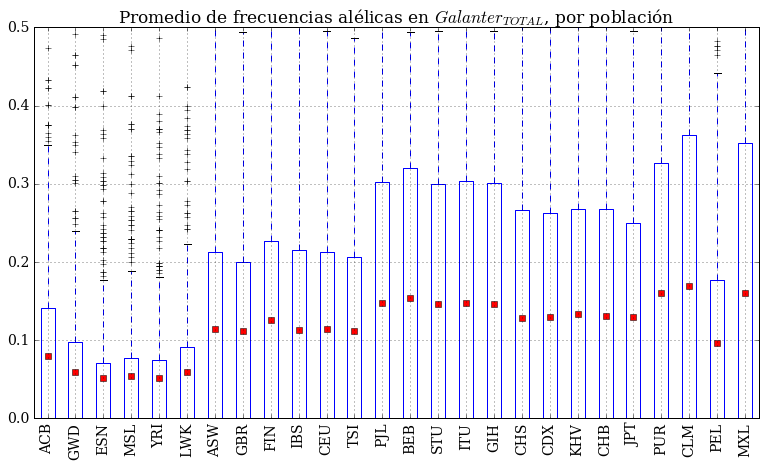

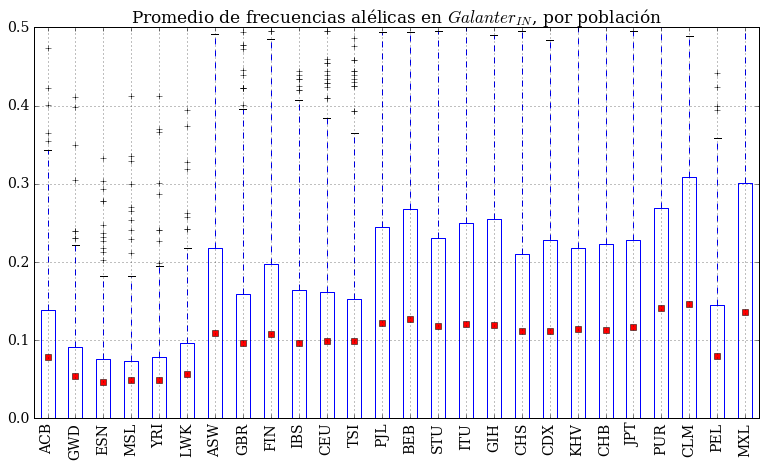

In [36]:
% run analyze_populations_in_galanter.py

populations_to_plot = []

for superpop in ['AFR', 'EUR', 'SAS', 'EAS', 'AMR']:
    pops = df_1000G_sample_populations[df_1000G_sample_populations.super_population == superpop].population.unique()
    populations_to_plot += list(pops)

dfs = {'$Galanter_{IN}$': present,
       '$Galanter_{TOTAL}$': galanter}

for name, df in dfs.items():
    df = df.join(maf_1000G).filter(regex='|'.join(populations_to_plot))
    df = df[populations_to_plot]
    
    ax = boxplot_freqs_by_populations(
        df, populations_to_plot,
        title="Promedio de frecuencias alélicas en {}, por población".format(name),
    )
    ax.set_ylim((0, 0.5))
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

/home/juan/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


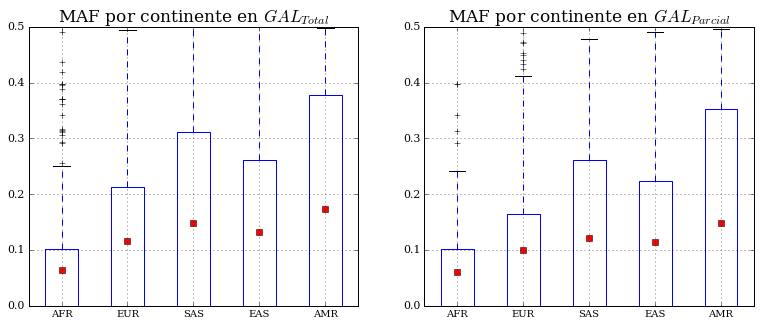

In [37]:
fig, axes = plt.subplots(1, 2, sharey=False)
titles = ("MAF por continente en $GAL_{Total}$",
          "MAF por continente en $GAL_{Parcial}$" )

for i, df in enumerate([galanter, present]):
    ax = axes[i]
    df = df.join(maf_1000G).filter(['AFR', 'EUR', 'SAS', 'EAS', 'AMR'])
    df.boxplot(ax=ax, rot=0, showmeans=True)
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_ylim((0, 0.5))
    ax.axhline(0.5, color='salmon', linestyle='--')

fig.set_figheight(5)
plt.show()

/home/juan/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


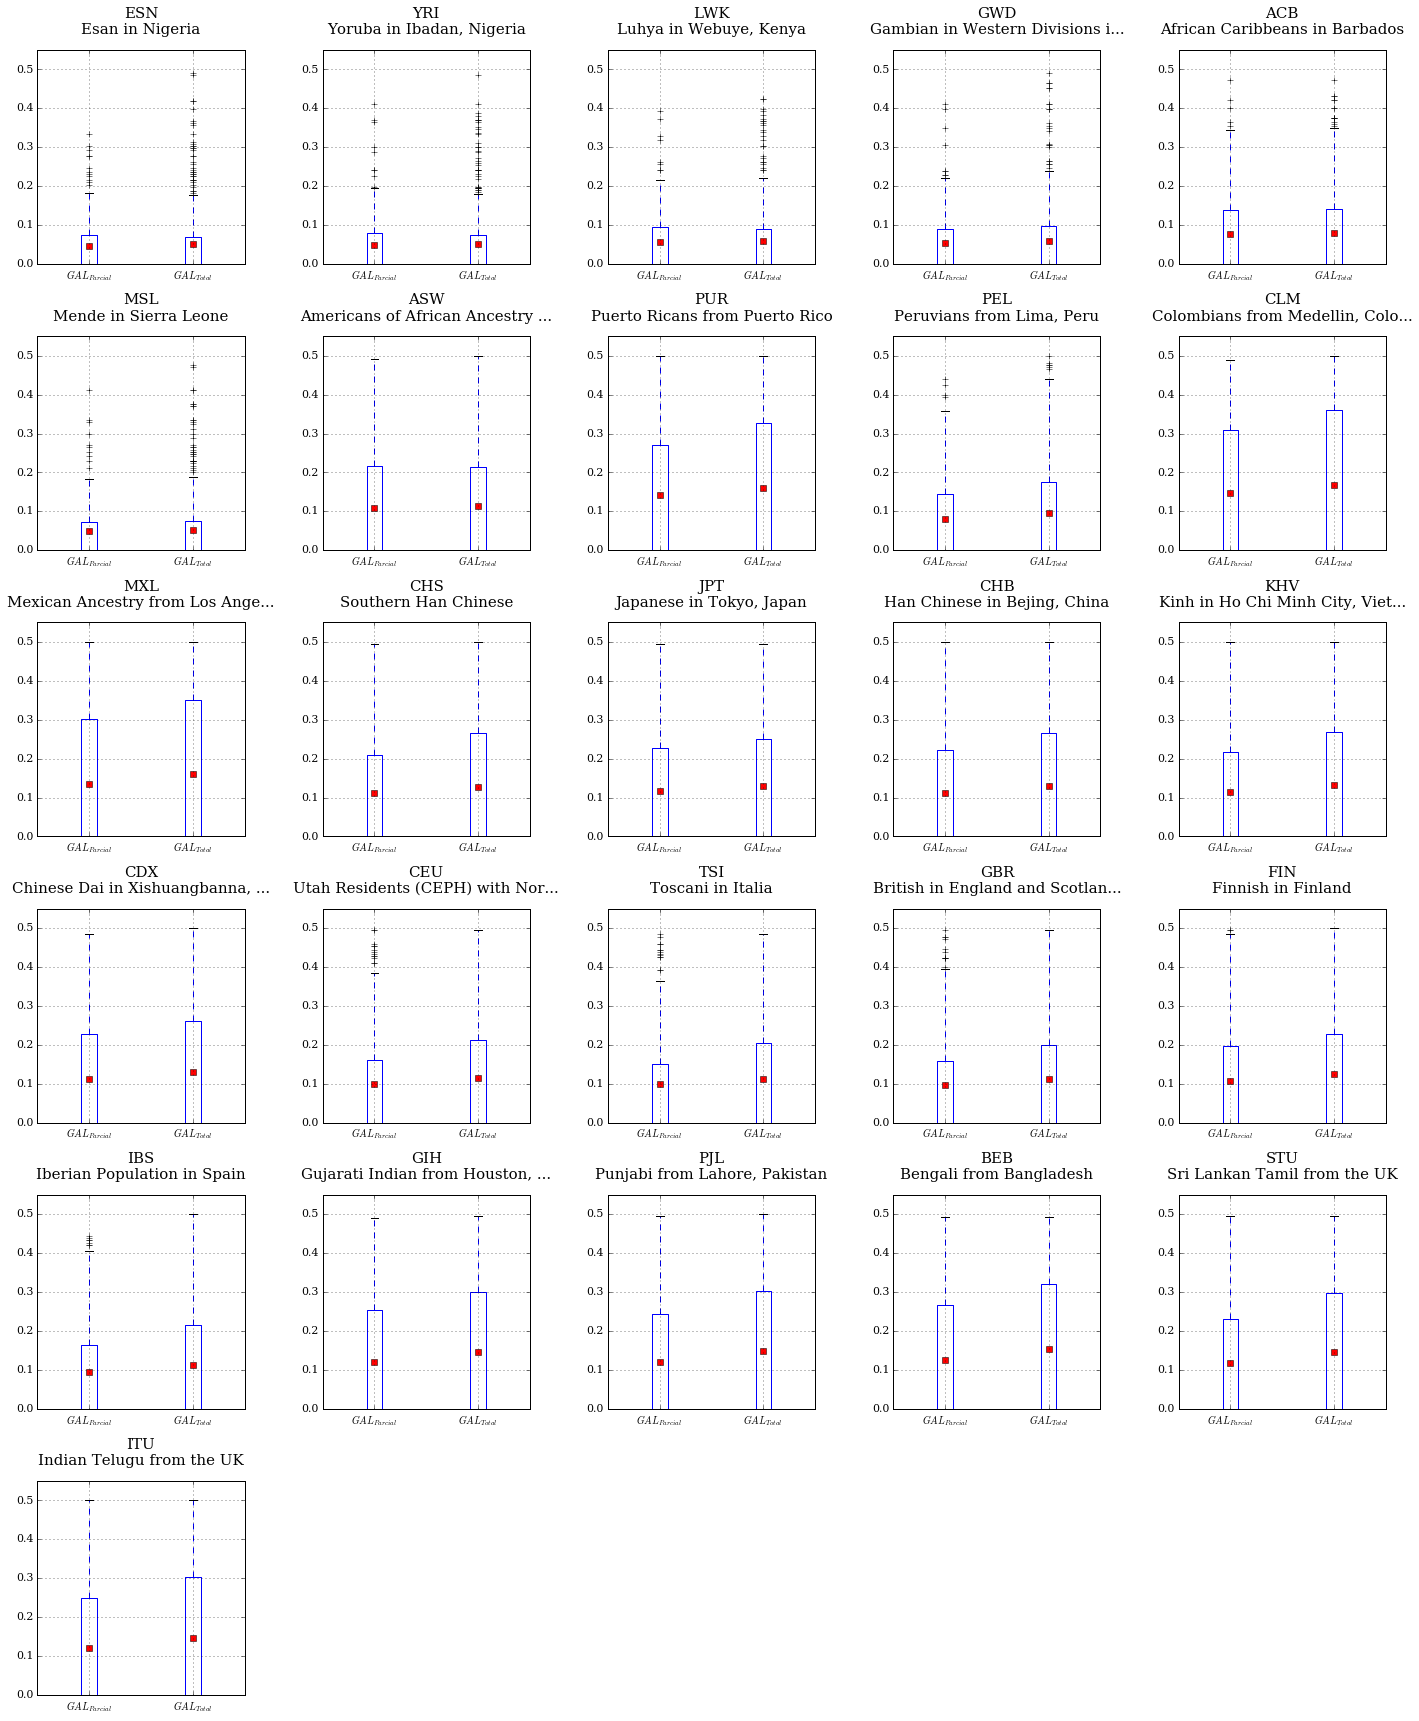

In [38]:
% run helpers/text_helpers.py

populations_to_plot = [p for p in df_1000G_sample_populations.sort('super_population')['population'].unique()]

get_freqs = lambda df: df.join(maf_1000G)[populations_to_plot]

chart_width = 4
chart_height = 4
fig_rows = 6
fig_cols = 5

fig = plt.figure(figsize=(fig_cols * chart_height, fig_rows * chart_width))

for i, population in enumerate(populations_to_plot):
    df = pd.DataFrame({'$GAL_{Parcial}$': get_freqs(present)[population],
                       '$GAL_{Total}$': get_freqs(galanter)[population]})

    ax = plt.subplot(fig_rows, fig_cols, i+1)
    pop_description = df_1000G_population_names.loc[population]['Population Description']
    ax.set_title(population + "\n" + trunc_text(pop_description, 30), y=1.05, fontsize=15)    
    df.boxplot(ax=ax, showmeans=True, return_type='both')
    ax.set_ylim((0, 0.55))

plt.tight_layout()
plt.show()

In [39]:
mean_frequencies = lambda df: maf_1000G.loc[df.index].mean()
std_frequencies = lambda df: maf_1000G.loc[df.index].std()

In [40]:
import numpy as np
from collections import OrderedDict

df = pd.DataFrame(OrderedDict([
    ('$GAL_{Total}$', mean_frequencies(galanter)),
    ('$GAL_{Parcial}$', mean_frequencies(present)),
    ('Freq. Diff.', mean_frequencies(galanter) - mean_frequencies(present)),
]))

df = df.applymap(lambda n: round(n, 2))
freq_diff = df.join(df_1000G_population_names[['Population Description', 'Super Population Code']]).fillna('')
freq_diff = freq_diff.rename(columns={'Population Description': 'Population'})
freq_diff = freq_diff.drop('Super Population Code', axis=1)
freq_diff = freq_diff[freq_diff['Population'] != '']  # Removes superpopulations
freq_diff.sort_values(by='Freq. Diff.', ascending=False, inplace=True)

### Comparación de la "heterocigosidad"

In [41]:
# galanter_heter = galanter.join(df_1000G_SNPs, rsuffix='_').heterozygosity
# present_heter = present.join(df_1000G_SNPs, rsuffix='_').heterozygosity

# plt.figure(figsize=(5, 5))
# ax = plt.subplot(111)
# ax.boxplot([galanter_heter, present_heter])
# # ax.set_xticklabels(['$Galanter_{TOTAL}$', '$Galanetr_{IN}$'])
# # ax.set_ylim([0, .55])
# plt.show()

# Read the Control Random-Panels

In [42]:
fn = "../1000Genomes_data/control-panel-factor1/panel_control.parsed.traw"
control_genotypes = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
control_genotypes.index = [sample.split("_")[0] for sample in control_genotypes.index]

In [43]:
fn = "../1000Genomes_data/control-panel-factor10/panel_control.parsed.traw"
control_2_genotypes = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
control_2_genotypes.index = [sample.split("_")[0] for sample in control_2_genotypes.index]

In [44]:
fn = "../1000Genomes_data/control-panel-factor100/panel_control.parsed.traw"
control_3_genotypes = pd.read_csv(fn, sep="\t", index_col="SNP").transpose()
control_3_genotypes.index = [sample.split("_")[0] for sample in control_3_genotypes.index]

# Preparar datos para PCA y ADMIXTURE

In [45]:
panel_indices = OrderedDict()
panel_indices["GAL Total"] = galanter.index
panel_indices["GAL Parcial"] = present.index
panel_indices["Panel Aleatorio x$10^1$ (432 SNPs)"] = control_genotypes.columns
panel_indices["Panel Aleatorio x$10^2$ (4.078 SNPs)"] = control_2_genotypes.columns
panel_indices["Panel Aleatorio x$10^3$ (40.728 SNPs)"] = control_3_genotypes.columns

# PCA

In [46]:
import yaml

plot_colors = yaml.load(open("data/plot_colors.yml", "r"))
plot_markers = yaml.load(open("data/plot_markers.yml", "r"))

## Preparar datasets de muestras elegidas

In [47]:
from collections import OrderedDict

samples = df_1000G_sample_populations

def merge_dicts(*dict_args):
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

def indices(pop_dict):  
    populations = []
    for label, pop_list in pop_dict.items():
        mask = samples.population.isin(pop_list)
        populations.append(samples[mask])

    return pd.concat(populations).index

datasets_general = OrderedDict()
datasets_by_pop = OrderedDict()

all_latinos = {'latinos': ['PEL', 'MXL', 'CLM', 'PUR']}
e = {'europeans': ['IBS', 'TSI']}
ea = merge_dicts(e, {'africans': ['YRI', 'LWK']})
eac = merge_dicts(ea, {'east_asians': ['CHB', 'CHS']})
eaci = merge_dicts(eac, {'south_asians': ['GIH']})

datasets_general['Latinos'] = all_latinos
datasets_general['Latinos, Europeos'] = merge_dicts(e, all_latinos)
datasets_general['Latinos, Europeos, Africanos'] = merge_dicts(ea, all_latinos)
datasets_general['Latinos, Europeos, Africanos, Chinos'] = merge_dicts(eac, all_latinos)
datasets_general['Latinos, Europeos, Africanos, Chinos, Indios'] = merge_dicts(eaci, all_latinos)

# Transform population codes into dataframe indices (sample IDs)
# And write the sample IDs list to a file with the dataset name
for dataset_group in [datasets_general, datasets_by_pop]:
    for label, pop_dict in dataset_group.items():
        dataset_group[label] = indices(pop_dict)
        filename = "_".join(label.replace("\n", " ").split(", ")).lower()
        dataset_group[label].values.tofile("../dataset_dumps/" + filename,
                                           sep="\n", format="%s")

In [48]:
all_controls = control_genotypes.combine_first(control_2_genotypes).combine_first(control_3_genotypes)
all_controls.shape

(2503, 44251)

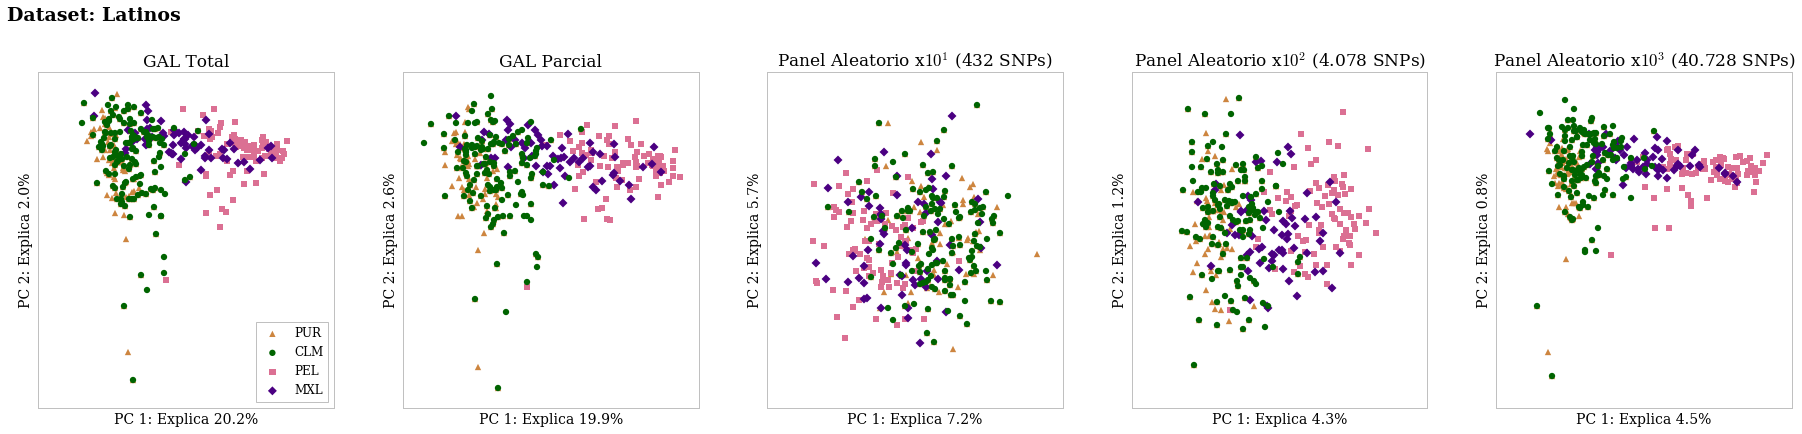

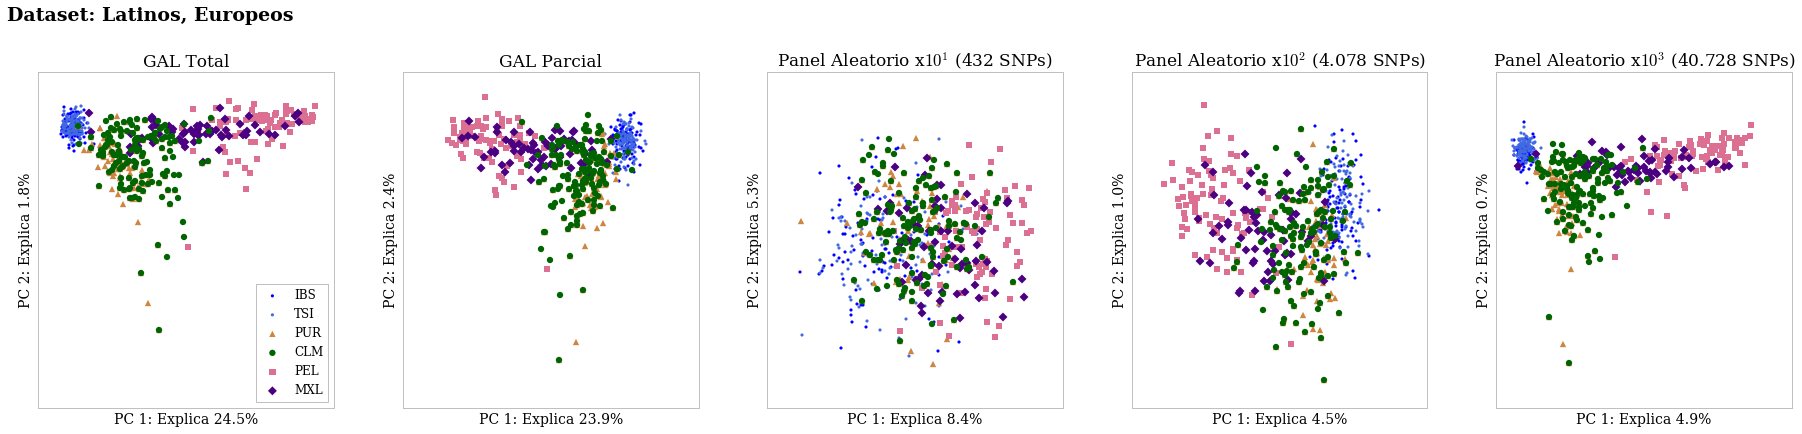

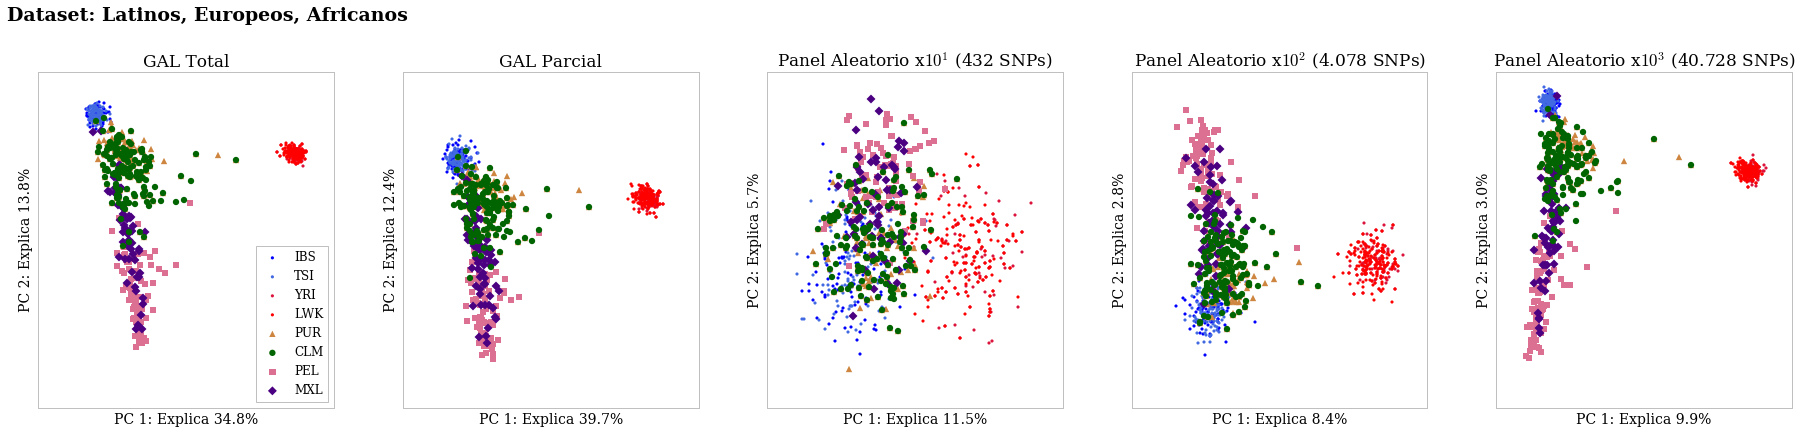

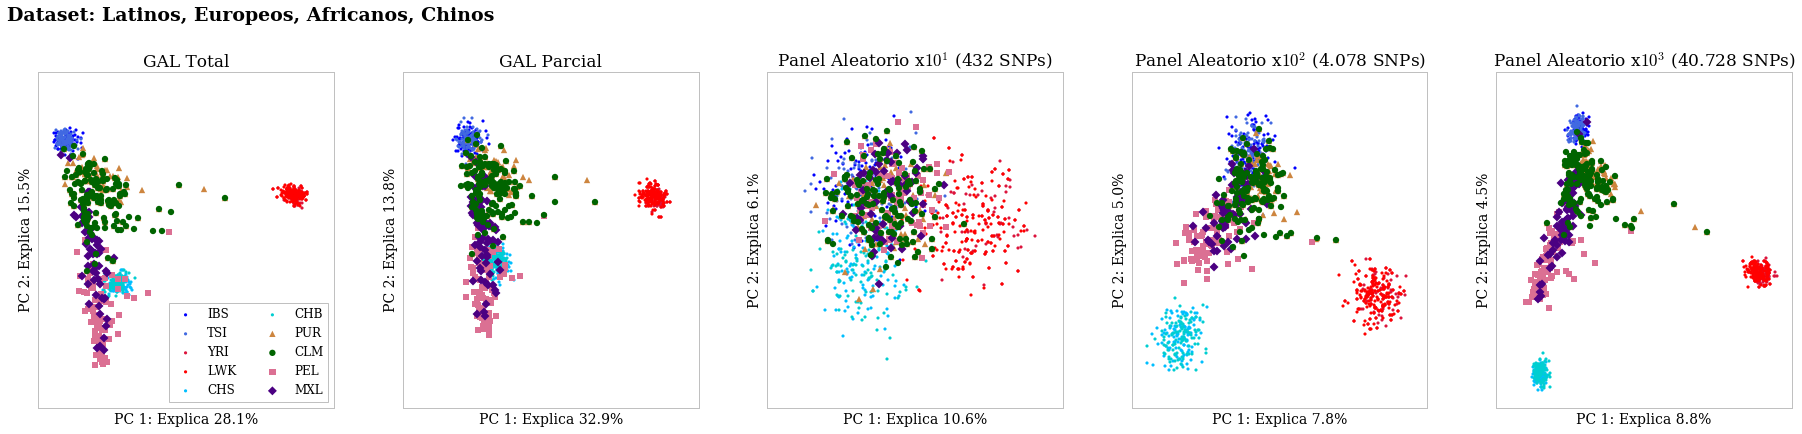

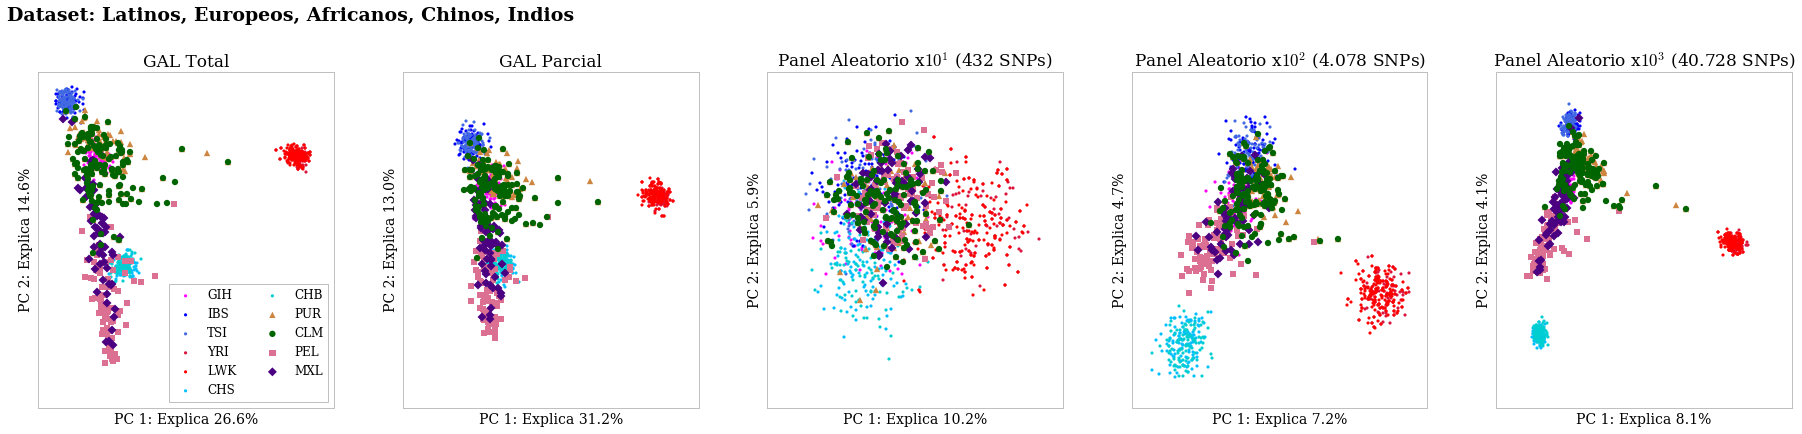

In [49]:
%run plot_PCAs.py

all_genotypes = df_1000G_genotypes.combine_first(all_controls)

for dataset_label, indices in datasets_general.items():
    genotypes = all_genotypes.loc[indices, :]
    
    pca = plot_PCAs(dataset_label, panel_indices, genotypes,
                    df_1000G_sample_populations,
                    plot_markers, plot_colors)

# Correr ADMIXTURE

In [110]:
# panels_indices = {
#     "galT": galanter.index,
#     "galP": present.index,
#     "controlx1": control_genotypes.columns,
#     "controlx10": control_2_genotypes.columns,
#     "controlx100": control_3_genotypes.columns,
# }

# for panel_tag, panel_indices in panels_.items():
#     df_1000G_SNPs.index.intersection(panel_indices).values.tofile(
#         "../admixture/{}.snps".format(panel_tag), sep="\n", format="%s"
#     )

* En `../admixture/` están los archivos `*.samples` con los sample IDs de 1000Genomas de cada dataset (`L`, `LE`, `LEA` ...).
* En el mismo directorio copié los bfiles (`.bed`, `.bim` ...) de PLINK de cada panel (`galT`, `galP`, `controlx1`, `controlx10`)
* Ahí mismo corrí `./create_datasets_run_admixture.sh <nombre-de-panel> <nombre-de-panel-2> ..`
* -> Se crean automáticamente directorios por cada combineta de dataset + panel con los archivos `*.P`

# Leer resultados de ADMIXTURE

## Plot CV Errors for different K values

Para generar el `CV_error_summary` que leo en la siguiente celda, me paré en `../admixture` y corrí:
```
grep CV */*.log > CV_error_summary
cat CV_error_summary | sed s'#[/:)]#,#g' | sed s'/CV error (K=//g' | awk -F, '{OFS=","; print $1, $3, $5}' | sed s'/, /,/g' > CV_error_summary.clean
```



In [121]:
dataset_names = {
    "L": "Latinos",
    "LE": "Latinos, Europeos",
    "LEA": "Latinos, Europeos, Africanos",
    "LEAC": "Latinos, Europeos,\nAfricanos, Chinos",
    "LEACI": "Latinos, Europeos,\nAfricanos, Chinos, Indios"
}

panel_names = {
    "galP": "GAL Parcial",
    "galT": "GAL Total",
    "controlx1": "Panel Aleatorio x$10^0$ (432 SNPs)",
    "controlx10": "Panel Aleatorio x$10^1$ (4.078 SNPs)",
    "controlx100": "Panel Aleatorio x$10^2$ (40.728 SNPs)",
}

/home/juan/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


AttributeError: 'NoneType' object has no attribute 'set_visible'

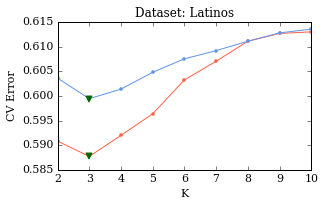

In [162]:
from itertools import product

! grep CV ../admixture/*/*.log > "CV_error_summary"
! cat "../admixture/CV_error_summary" | sed s'#[/:)]#,#g' | sed s'/CV error (K=//g' | awk -F, '{OFS=","; print $1, $3, $5}' | sed s'/, /,/g' > "../admixture/CV_error_summary.clean"

plot_panel_colors = {
    "galP": "Tomato",
    "galT": "CornflowerBlue",
    "controlx1": "#555555",
    "controlx10": "#666666",
    "controlx100": "#777777",
}

cv_errors = pd.read_csv("../admixture/CV_error_summary.clean",
                        names=['dataset_panel', 'K', 'CV_error'])

cv_errors['dataset'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[0])
cv_errors['panel'] = cv_errors['dataset_panel'].apply(lambda x: x.split("_")[1])
cv_errors = cv_errors.drop('dataset_panel', axis=1)
cv_errors = cv_errors.set_index(['dataset', 'panel', 'K']).sort_index()


Ks = cv_errors.index.get_level_values('K').unique()

width, height = (5, 3)
cols, rows = (2, 3)
fig = plt.figure(figsize=(width * cols, height * rows))
axes = list(np.arange(cols * rows) + 1)
axes.reverse()

datasets = cv_errors.index.get_level_values('dataset').unique()
for dataset in datasets:
    
    ax1 = plt.subplot(rows, cols, axes.pop())
    ax2 = ax.twinx()  # Needed to plot the control panels in a different Y axis scale
    lines = []
    
    panels = cv_errors.loc[dataset].index.get_level_values('panel').unique()
    for panel in panels:
        ax = ax2 if "control" in panel else ax1

        data = cv_errors.loc[(dataset, panel)]            
        data.plot(ax=ax, marker=".", color=plot_panel_colors[panel], zorder=1)
        
        x_min = data['CV_error'].idxmin()
        y_min = data['CV_error'].min()
        min_marker = ax.scatter(x_min, y_min, marker="v", color="DarkGreen", zorder=2, s=35)
        
        # TODO: Add a special mark at the minimum y value
    
    lines, labels = ax1.get_legend_handles_labels()
    panel_labels = [panel_names[panel] for panel in panels]
    ax1.set_title("Dataset: " + dataset_names[dataset], fontsize=12)
    ax1.set_ylabel("CV Error", fontsize=11)
    ax1.set_xlabel("K", fontsize=11)
    
    for ax_ in [ax1, ax2]:
        ax_.legend().set_visible(False)

# Ugly hack to get the legend in a separate subplot slot
ax = plt.subplot(rows, cols, axes.pop())
ax.legend(lines + [min_marker], panel_labels + ['Valor óptimo de K'],
          fontsize=13, loc='upper left', fancybox=True, scatterpoints=1)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
for loc in ['top', 'bottom', 'left', 'right']:
    ax.spines[loc].set_visible(False)

plt.tight_layout()
plt.show()

## Plot ADMIXTURE ancestry ratios per individual

In [52]:
from collections import OrderedDict
from collections import defaultdict


dataset_Ks = OrderedDict([("L", 3), ("LE", 3), ("LEA", 3), ("LEAC", 4), ("LEACI", 5)])
panels = ["galT", "galP"]
admixture_results = defaultdict(OrderedDict)
ancestral_components = {0: 'EUR', 1: 'NAM', 2: 'AFR', 3: 'EAS', 4: 'SAS'}

population_groups = OrderedDict([
    ('Latinos',   ['CLM', 'MXL', 'PEL', 'PUR']),
    ('Europeos',  ['TSI', 'IBS']),
    ('Africanos', ['LWK', 'YRI']),
    ('Chinos',    ['CHS', 'CHB']),
    ('Indios',    ['GIH'])
])

In [53]:
for dataset_tag, optimal_K in dataset_Ks.items():
    for panel_tag in panels:
        fdir = "../admixture/{}_{}/".format(dataset_tag, panel_tag)
        filename = "{}_{}.{}.Q".format(dataset_tag, panel_tag, optimal_K)
        samples_filename = "{}_{}.fam".format(dataset_tag, panel_tag)
        ancestry_values = pd.read_csv(fdir + filename, sep="\s+",
                                      names=list(range(optimal_K)))
        sample_ids = pd.read_csv(fdir + samples_filename, sep="\s+",
                                 index_col=0, usecols=[0], names=['sample_id'])
        ancestry_values['sample_id'] = sample_ids.index
        populations = df_1000G_sample_populations.loc[sample_ids.index]['population']
        ancestry_values['population'] = populations.values
        ancestry_values['super_population'] = [df_1000G_population_names.loc[population]['Super Population Code']
                                               for population in populations.values]

        # Reorder ancestry columns to always have the same ancestral populations
        # in the same positions (and then the same order and colors in the plots).
        # This is almost necessarily hardcoded after visual inspection of the plots.
        fixed_columns = ['sample_id', 'population', 'super_population']
        if panel_tag == "galT":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[1, 3, 2, 0] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[3, 0, 2, 1, 4] + fixed_columns]
        if panel_tag == "galP":
            if dataset_tag == "L":
                ancestry_values = ancestry_values[[2, 0, 1] + fixed_columns]
            if dataset_tag == "LE":
                ancestry_values = ancestry_values[[2, 1, 0] + fixed_columns]
            if dataset_tag == "LEA":
                ancestry_values = ancestry_values[[1, 2, 0] + fixed_columns]
            if dataset_tag == "LEAC":
                ancestry_values = ancestry_values[[3, 1, 0, 2] + fixed_columns]
            if dataset_tag == "LEACI":
                ancestry_values = ancestry_values[[3, 0, 2, 1, 4] + fixed_columns]

        # Reassign the column numbers
        columns_renumbered = list(range(len(ancestry_values.columns) - len(fixed_columns)))
        ancestry_values.columns = (columns_renumbered + fixed_columns)
        
        # Replace the numbers with the continental population codes
        # This naming of the ancestry columns only makes sense with the previous ordering,
        # which placed the components in the same order as the one in "ancestral_components"
        renamed_columns = [ancestral_components[n] for n in ancestry_values.columns
                          if n not in fixed_columns]
        ancestry_values.columns = renamed_columns + fixed_columns
        
        # Reorder the named columns
        ancestral_components_ordered = list(ancestral_components.values())[:len(renamed_columns)]
        ancestry_values = ancestry_values[ancestral_components_ordered + fixed_columns]

        # Sort the samples
        ancestry_values = ancestry_values.sort_values(['super_population', 'population', 'EUR'])
        ancestry_values = ancestry_values.reset_index(drop=True)

        admixture_results[dataset_tag][panel_tag] = ancestry_values

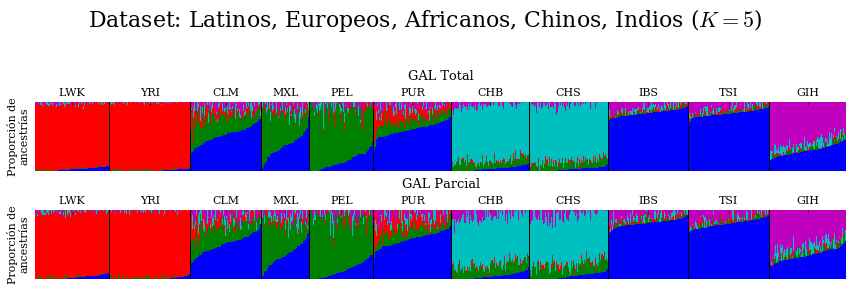

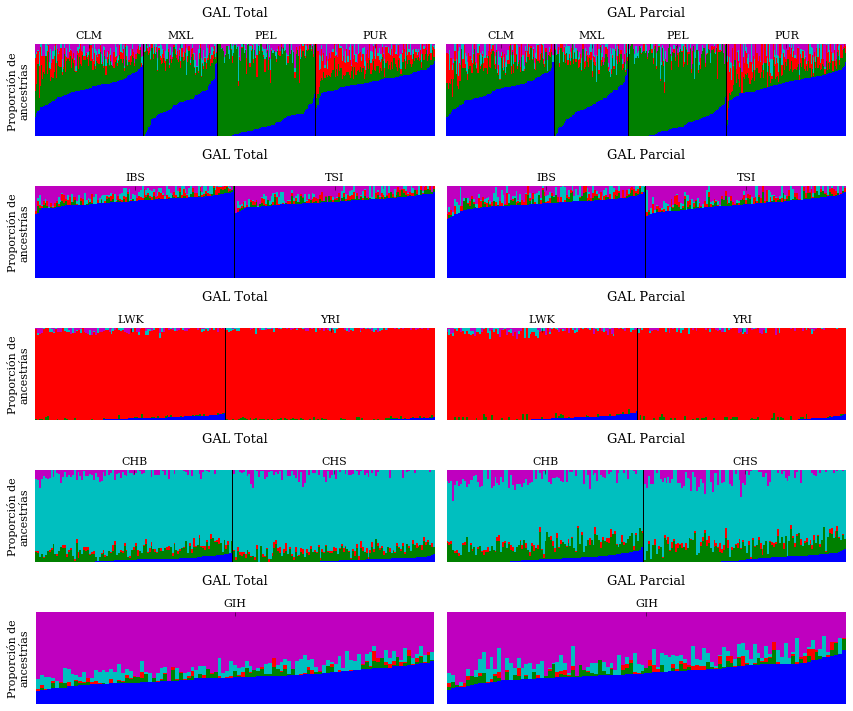

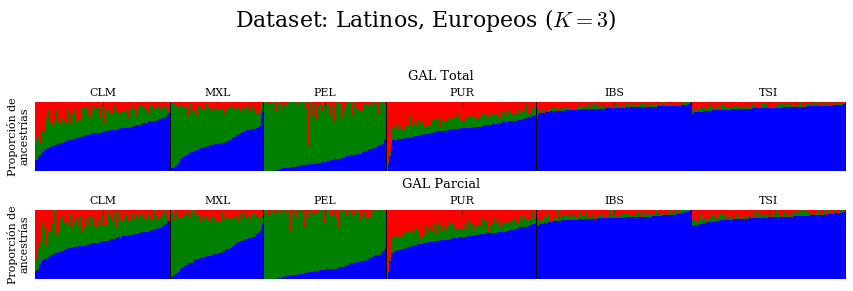

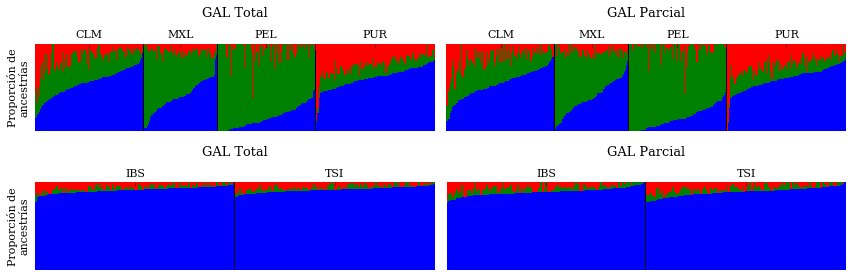

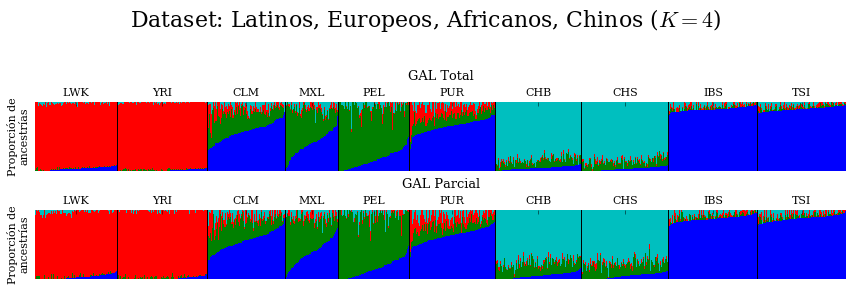

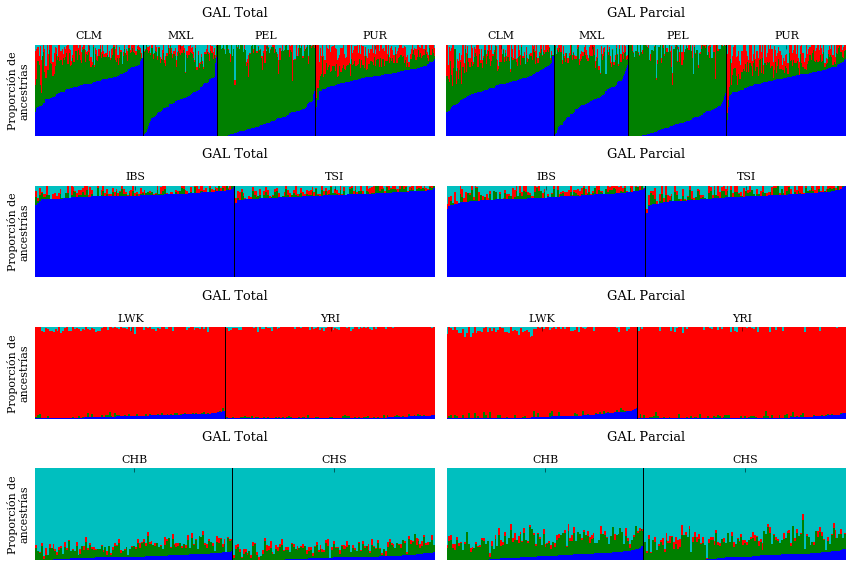

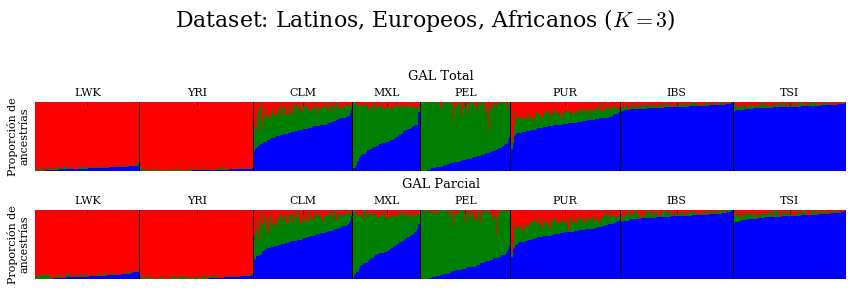

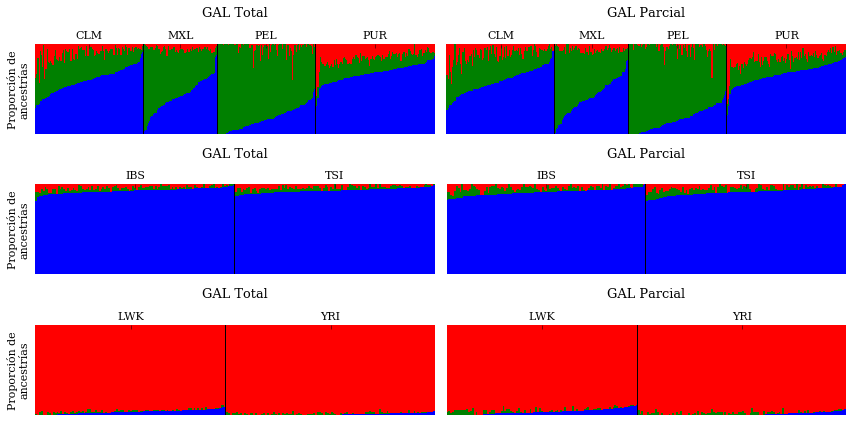

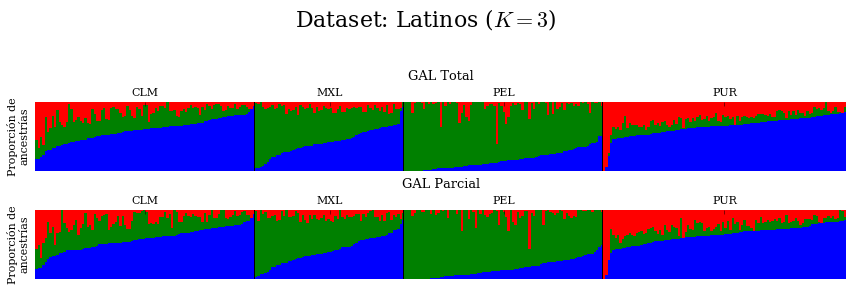

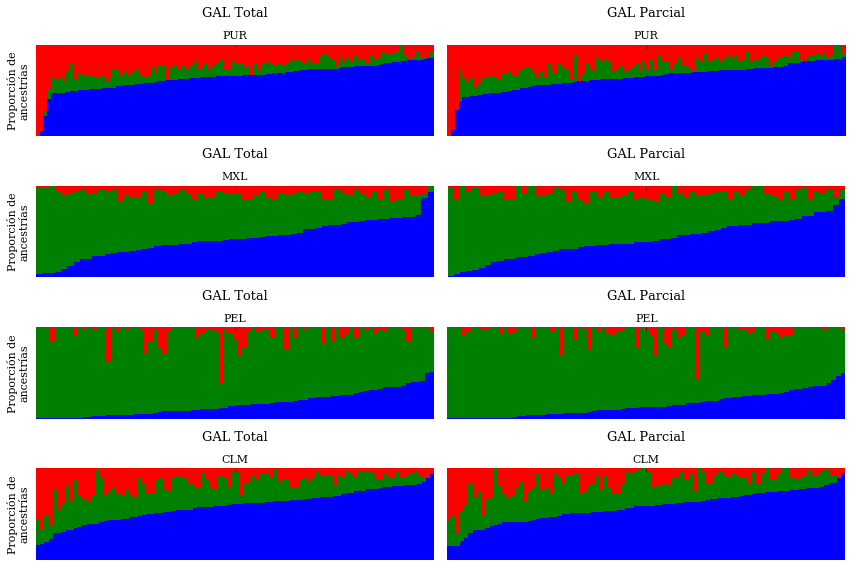

In [54]:
from collections import OrderedDict


def config_admixture_plot(ax, df, ylabel_on=True):
    ax.set_title(panel_name, fontsize=13, position=(0.5, 1.25))
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    # Set population names on the xticks
    indices_by_population = [df[df['population'] == population].index.values
                             for population in df['population'].unique()]
    xtick_positions = [np.median(indices) for indices in indices_by_population]
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(df['population'].unique(), rotation=0)
    ax.xaxis.set_ticks_position("top")

    # Separate the populations with a line
    
    separation_lines = [max(indices) for indices in indices_by_population]
    [plt.axvline(x=x, color="k", lw=1) for x in separation_lines[:-1]]

    if ylabel_on:
        ax.set_ylabel("Proporción de\nancestrías", fontsize=11)
        
    ax.set_ylim((0, 1))
    ax.set_yticks([])
    ax.set_frame_on(False)
    ax.legend().set_visible(False)

    return ax

for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
        
    # One figure per panel per dataset on top
    
    rows = len(panels)
    fig = plt.figure(figsize=(12, 2 * rows))
    axes = (np.arange(len(panels)) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
        ax = plt.subplot(rows, 1, axes.pop())
        df.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
        ax = config_admixture_plot(ax, df)
    
    plt.tight_layout()
    
    title = "Dataset: {} ($K={}$)".format(dataset_name, K)
    fig.suptitle(title, fontsize=22, fontweight="ultralight", variant="small-caps")
    plt.subplots_adjust(top=(0.65))
    
    plt.show()
    
    # Detail plots for each population group
    
    # Detail plots dimensions and subplot number generation
    width, height = (6, 2)
    
    # Hacky! Dataset tags are acronyms of the population groups
    # So I'm inferring the number of population group from the length of the tag.
    cols, rows = (2, len(dataset_tag))  # One row of plots per population group
    
    if dataset_tag == "L":
        rows = len(population_groups["Latinos"])
    
    fig = plt.figure(figsize=(width * cols, height * rows))

    odd_subplots = [n for n in np.arange(rows * cols) + 1 if n % 2 != 0]
    even_subplots = list(np.array(odd_subplots) + 1)
    axes = {"galT": odd_subplots[::-1], "galP": even_subplots[::-1]}

    sorted_index = []  # Hack. See (1) below.

    # One subplot per population group per panel in the dataset
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
        
        if dataset_tag == "L":
            # Hack to get one plot per latino population in this dataset
            pg = dict([(p, [p]) for p in population_groups["Latinos"]])
        else:
            pg = population_groups
            
        for population_group_name, population_group in pg.items():
            mask = df['population'].isin(population_group)
            df_pop = df[mask].dropna()
            if len(df_pop) == 0:
                continue
    
            # (1) Hack to get the same sample order in both columns of plots
            if panel_tag == "galT":
                sorted_index = [df_pop.index] + sorted_index
            elif panel_tag == "galP":
                df_pop = df_pop.loc[sorted_index.pop()]

            # I need consecutive indices for the xtick labels position calculation later:
            df_pop = df_pop.reset_index(drop=True)
            
            ax_id = axes[panel_tag].pop()
            ax = plt.subplot(rows, cols, ax_id)
            df_pop.plot(ax=ax, kind="bar", stacked=True, width=1, linewidth=0)
            
            ylabel_on = (ax_id % 2 != 0)  # Y-axis label only on plots on the left (odd plots)
            title_on = (ax_id in [1, 2])  # Only top plots carry the panel_name as title

            ax = config_admixture_plot(ax, df_pop, ylabel_on=ylabel_on)

    plt.tight_layout()
    plt.show()

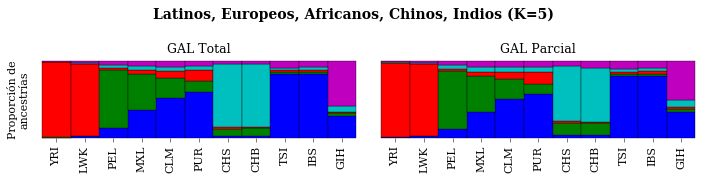

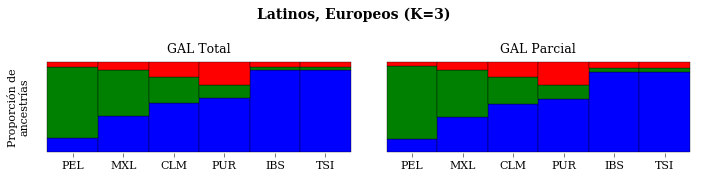

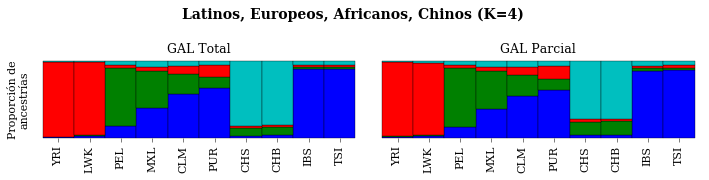

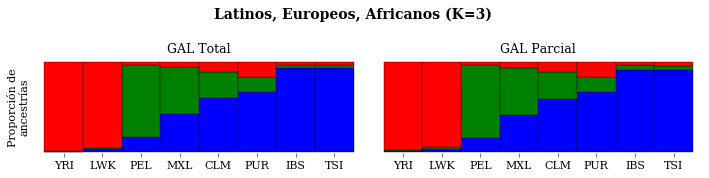

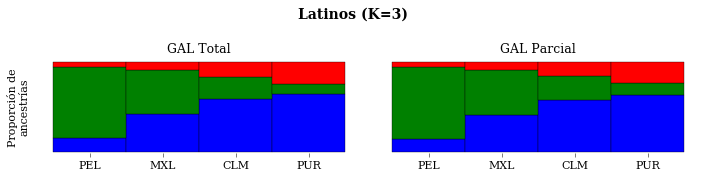

In [55]:
def get_superpop_from_poptag(tag):
    ref = df_1000G_population_names

    if tag not in ref.index:
        return tag
    
    return ref.loc[tag]['Super Population Code']

def config_admixture_mean_plot(ax, df, title=None, ylabel_on=True):
    if title:
        ax.set_title(title, fontsize=12.5)

    if ylabel_on:
        ax.set_ylabel("Proporción de\nancestrías", fontsize=11)

    ax.set_ylim((-0.05, 1.05))
    ax.set_yticks([])
    
    xticklabels = plt.xticks()[1]
    xticks_rot = 0 if len(xticklabels) < 10 else 90
    ax.set_xticklabels(xticklabels, rotation=xticks_rot)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel("")
    ax.set_frame_on(False)
    ax.legend(loc="center left", fontsize=10).set_visible(False)

    return ax


for dataset_tag, panel_results in admixture_results.items():
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
    
    rows, cols = 1, len(panels)
    width, height = 5, 2.5
    fig = plt.figure(figsize=(cols * width, rows * height))
    axes = (np.arange(rows * cols) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        
        panel_name = panel_names[panel_tag]
        ax_id = axes.pop()
        ax = plt.subplot(rows, cols, ax_id)
        
        by_population = df.groupby("population").mean()
        # by_superpopulation = df.groupby("super_population").mean()
        # both = pd.concat([by_population, by_superpopulation])

        by_population["superpop"] = [get_superpop_from_poptag(ix)
                                     for ix in by_population.index.values]
        by_population = by_population.sort_values(["superpop", "EUR"])
        
        by_population.plot(ax=ax, kind="bar", stacked=True, width=1, lw=0.35, rot=0)
        config_admixture_mean_plot(ax, by_population, title=panel_name,
                                   ylabel_on=(ax_id % 2 != 0))
    
    figtitle = "{} (K={})".format(dataset_name, K)
    fig.suptitle(figtitle, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(top=(0.70))
    plt.show()

## Triangular plot or 3D plot with the K=3 values

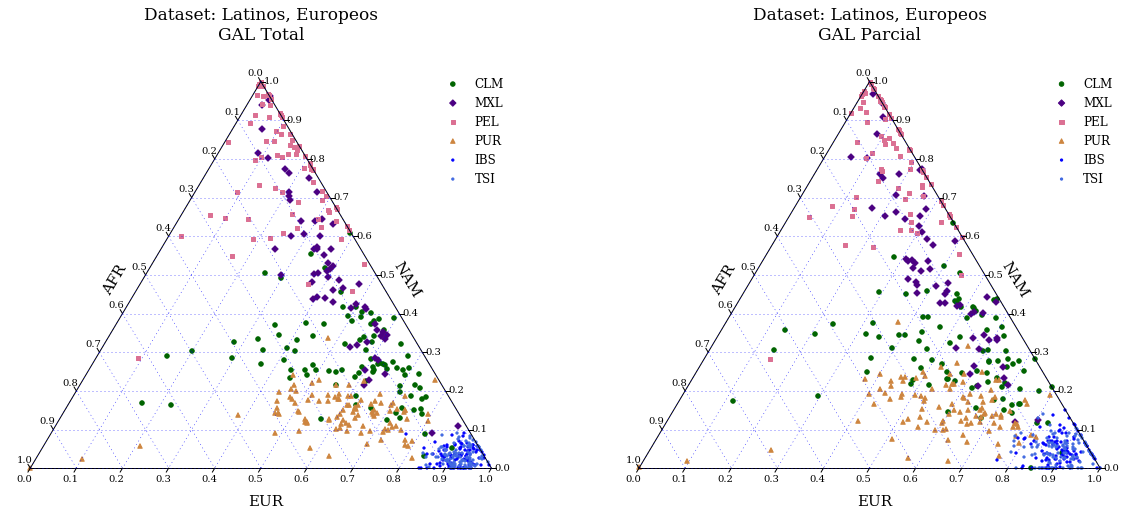

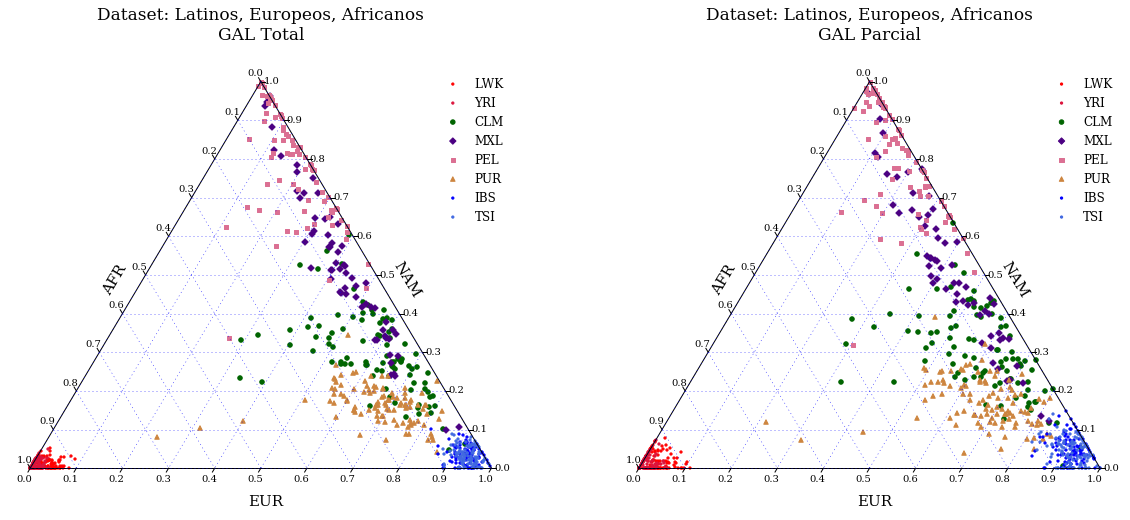

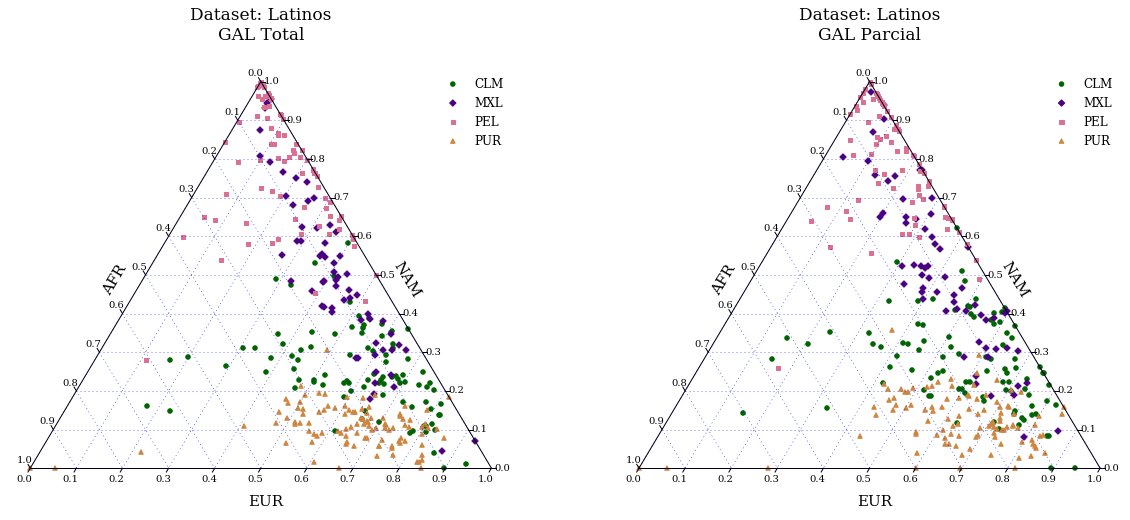

In [56]:
import ternary


for dataset_tag, panel_results in admixture_results.items():
    if len(dataset_tag) > 3:
        continue
    
    K = dataset_Ks[dataset_tag]
    dataset_name = dataset_names[dataset_tag].replace("\n", " ")
    
    rows, cols = 1, len(panels)
    width, height = 10, 8
    fig = plt.figure(figsize=(cols * width, rows * height))

    axes = (np.arange(rows * cols) + 1).tolist()[::-1]
    
    for panel_tag, df in panel_results.items():
        panel_name = panel_names[panel_tag]
            
        ax_id = axes.pop()
        ax = plt.subplot(rows, cols, ax_id)
        ax.axis("off")
        fig, tax = ternary.figure(scale=1, ax=ax)

        for population in df['population'].unique():
            mask = df['population'] == population
            tax.scatter(df[mask].iloc[:, :3].as_matrix(), label=population,
                        color=plot_colors[population], marker=plot_markers[population])

        tax.set_title("Dataset: {}\n{}".format(dataset_name, panel_name),
                      position=(0.5, 1.05))

        tax.boundary(linewidth=1)

        fontsize = 15
        tax.left_axis_label(df.columns[2], fontsize=fontsize)
        tax.bottom_axis_label(df.columns[0], fontsize=fontsize)
        tax.right_axis_label(df.columns[1], fontsize=fontsize)

        tax.ticks(axis="lbr", linewidth=1, multiple=0.1)
        tax.gridlines(multiple=0.1)
        tax.legend(frameon=False, fontsize=12, scatterpoints=1)

        tax.clear_matplotlib_ticks()

    plt.show()

# Read HDGP markers

Para descargar los datos de HGDP usé ftp_download_HGDP.py

## CEPH dataset

In [57]:
fn = "../HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-marker.out"
hgdp_ceph_markers = pd.read_csv(fn, sep="\t")
hgdp_ceph_markers = hgdp_ceph_markers.rename(columns={"chrom": "chr", "physical_pos": "pos"})
mask = hgdp_ceph_markers["type_marker"].isin(["SNP", "snp"])
hgdp_ceph_markers = hgdp_ceph_markers[mask].reset_index(drop=True)

In [58]:
fn = "../HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-geno.out"
# Filter only biallelic SNPs!
hgdp_ceph_genotypes = pd.read_csv(fn, sep="\t", index_col="hgdp_id")
hgdp_ceph_genotypes.head(2)

,pop_id,mkr_ceph_id,allele1,allele2
hgdp_id,,,,
HGDP00001,12,22,15,7
HGDP00003,12,22,16,14


In [59]:
# Filtrar esos 5,4 M de genotipos por el mkr_ceph_id de los rs de galanter
# ojo con la RAM!

## Stanford dataset

In [60]:
fn = "../HGDP_data/dataset_2_supp1_Stanford/hgdp/HGDP_Map.txt"
hgdp_stanford_markers = pd.read_csv(fn, sep="\t", names=["dbsnp_id", "chr", "pos"],
                                    index_col="dbsnp_id")

## Uni of Michigan dataset

In [61]:
from glob import glob
from os.path import isfile

dumpfile = "./dumpfiles/HGDP_michigan_markers.csv"

if isfile(dumpfile):
    dtypes = {"dbsnp_id": str, "chr": str, "pos_build_36": int, "pos_build_35": int}
    hgdp_michigan_markers = pd.read_csv(dumpfile, index_col="dbsnp_id", dtype=dtypes)
else:    
    markers_per_chr = []
    
    # The *.map files were generated with "parse_HGDP_UMichigan_data.sh"
    for fn in glob("../HGDP_data/dataset_3_supp2_UMichigan/GENO/chr*.map"):
        markers_per_chr.append(pd.read_csv(fn, sep="\s+").transpose())

    hgdp_michigan_markers = pd.concat(markers_per_chr).drop(0, axis=1)
    hgdp_michigan_markers.columns = ["chr", "pos_build_36", "pos_build_35"]
    hgdp_michigan_markers["pos"] = hgdp_michigan_markers["pos_build_36"]
    hgdp_michigan_markers.index.name = "dbsnp_id"
    hgdp_michigan_markers.to_csv(dumpfile)

## Max Plank Institute datset

In [62]:
fn = "../HGDP_data/dataset_4_supp3_MPlank/hgdpceph.affy500k.map.gz"
hgdp_maxplank_markers = pd.read_csv(fn, sep="\t", names=["chr", "dbsnp_id", "?", "pos"],
                                    usecols=["chr", "dbsnp_id", "pos"], index_col="dbsnp_id")

## Harvard dataset

In [63]:
fn = "../HGDP_data/dataset_11_supp10_Harvard/Harvard_HGDP-CEPH/all_snp.map.gz"
hgdp_harvard_markers = pd.read_csv(fn, sep="\t", names=["chr", "Affy SNP ID", "?", "pos"],
                                   usecols=["chr", "Affy SNP ID", "pos"])

fn = "../HGDP_data/dataset_11_supp10_Harvard/Axiom_GW_HuOrigin.na35.annot.csv.tar.gz"
affy_human_origins = pd.read_csv(fn, comment="#", skiprows=1, index_col="Affy SNP ID",
                                 usecols=["Affy SNP ID", "dbSNP RS ID"])

hgdp_harvard_markers = hgdp_harvard_markers.set_index("Affy SNP ID")
hgdp_harvard_markers = hgdp_harvard_markers.join(affy_human_origins)
hgdp_harvard_markers = hgdp_harvard_markers.rename(columns={"dbSNP RS ID": "dbsnp_id"})

## UCLA dataset

In [64]:
fn = "../HGDP_data/dataset_15_supp15_UCLA/snp_info.csv"
hgdp_ucla_markers = pd.read_csv(fn, names=["_", "_", "chr", "pos", "dbsnp_id"],
                                usecols=["chr", "pos", "dbsnp_id"], skiprows=1).dropna()

## Intersection GAL x HGDP

In [65]:
hgdp_panels = {
    "CEPH": hgdp_ceph_markers,
    "Stanford": hgdp_stanford_markers,
    "MaxPlank": hgdp_maxplank_markers,
    "Harvard": hgdp_harvard_markers,
    "UCLA": hgdp_ucla_markers,
    "UMichigan": hgdp_michigan_markers,
}

In [66]:
galanter_HGDP_matches = pd.DataFrame({"dbsnp_id": galanter.index})
galanter_HGDP_matches = galanter_HGDP_matches.set_index("dbsnp_id")

for panel_name, markers in hgdp_panels.items():
    print(panel_name, len(markers))
    galanter_HGDP_matches[panel_name] = \
        galanter_HGDP_matches.index.map(lambda x: x in markers.index.values)

galanter_HGDP_matches["hits"] = galanter_HGDP_matches.sum(axis=1)

UCLA 160743
Stanford 660918
MaxPlank 488755
CEPH 5662
UMichigan 525910
Harvard 631708


/home/juan/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [67]:
galanter_hgdp_indices = {}

print("Galanter Matches in HGDP panels:")
for hgdp_panel_name, markers in hgdp_panels.items():
    matches = galanter_HGDP_matches[hgdp_panel_name]
    intersection_count = len(matches[matches])
    
    if intersection_count > 0:
        galanter_hgdp_indices[hgdp_panel_name] = {}
        galanter_hgdp_indices[hgdp_panel_name]["galT"] = galanter_HGDP_matches[matches].index
        galanter_hgdp_indices[hgdp_panel_name]["galP"] = \
            galanter_HGDP_matches[matches].loc[present.index].dropna(axis=0).index
        
        print("-")
        print(hgdp_panel_name, "galT ->",
              len(galanter_hgdp_indices[hgdp_panel_name]["galT"]))
        print(hgdp_panel_name, "galP ->",
              len(galanter_hgdp_indices[hgdp_panel_name]["galP"]))

Galanter Matches in HGDP panels:
-
Stanford galT -> 179
Stanford galP -> 74
-
MaxPlank galT -> 341
MaxPlank galP -> 145
-
UMichigan galT -> 169
UMichigan galP -> 71


# HGDP populations

In [68]:
hgdp_continents = {
    "Asia": "ASN",
    "Subsaharian Africa": "AFR",
    "Oceania": "EAS",
    "Europe": "EUR",
    "Middle Est": "WAS",
    "America": "AMR",
    "North Africa": "AFR",
}

### CEPH populations

In [69]:
fn = "../HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-pop.out"
usecols = ["population_name", "population_id", "nickname"]
hgdp_populations_detail = pd.read_csv(fn, sep="\t", usecols=usecols)
hgdp_populations_detail.set_index("population_name", inplace=True)

In [70]:
popcodes = dict(zip(hgdp_populations_detail.index.values,
                    hgdp_populations_detail["nickname"].values))

In [71]:
fn = "../HGDP_data/dataset_1_HGDP-CEPH_v3/hgdp-ceph-unrelated.out"
hgdp_samples = pd.read_csv(fn, sep="\t", index_col="hgdp_id")
hgdp_samples["continent"] = hgdp_samples["Region"].map(hgdp_continents)
hgdp_samples["population_name"] = hgdp_samples["population"]
hgdp_samples["population"] = hgdp_samples["population_name"].map(popcodes)

In [72]:
regions = dict(zip(hgdp_samples["population_name"],
                   hgdp_samples["Region"]))
continents = dict(zip(hgdp_samples["population_name"],
                      hgdp_samples["continent"]))

In [73]:
hgdp_populations_detail["continent"] = \
    hgdp_populations_detail.index.map(lambda x: continents[x])
hgdp_populations_detail["region"] = \
    hgdp_populations_detail.index.map(lambda x: regions[x])

### MaxPlank populations

In [74]:
corrections = {
    "Colombian": "Colombians",
    "Cambodian": "Cambodians",
    "MbutiPygmy": "Mbuti_Pygmies",
    "NewGuinea": "Papuan",
}

superpops = {
    "Nasioi": "EAS",
    "BiakaPygmy": "AFR",
    "Bantu": "AFR",
    "Basque": "EUR",
    "Bergamo": "EUR",
}

def fix_popnames(popname):
    if popname not in corrections.keys():
        return popname
    
    return corrections[popname]

def get_superpop(popname):
    if popname in hgdp_populations_detail.index:
        return hgdp_populations_detail.loc[popname]["continent"]

    if popname in superpops.keys():
        return superpops[popname]
    
    return "Unknown"

In [75]:
fn = "../HGDP_data/dataset_4_supp3_MPlank/hgdpceph.affy500k.pedind"
mplank_populations = pd.read_csv(fn, sep="\s+",
                                 names=[".", "sample", ".", ".", ".", "population"],
                                 usecols=["sample", "population"])
mplank_populations.set_index("sample", inplace=True)
mplank_populations["population"] = mplank_populations["population"].map(fix_popnames)
mplank_populations["continent"] = mplank_populations["population"].map(get_superpop)

# HGDP genotypes and populations read

In [76]:
hgdp_genotypes = defaultdict(OrderedDict)

## MaxPlank dataset

In [77]:
fn = "../HGDP_data/dataset_4_supp3_MPlank/hgdpceph.affy500k.AT.traw.parsed"
df = pd.read_csv(fn, sep="\s+")
renamed_columns = [s.split("_")[-1] for s in df.columns]
df.columns = renamed_columns
df.rename(columns={"SNP": "dbsnp_id"}, inplace=True)
df.set_index("dbsnp_id", inplace=True)

for panel_name in panels:
    indices = galanter_hgdp_indices["MaxPlank"][panel_name]
    hgdp_genotypes["MaxPlank"][panel_name] = df.loc[indices]

df = None # Hope this cleans the big dataframe from memory?

In [78]:
latinos = ['Colombians', 'Karitiana', 'Maya', 'Surui', 'Pima']
europeans = ['Basque', 'Bergamo', 'French']
africans = ['BiakaPygmy' 'Bantu', 'Mandenka']
middle_eastern = ['Balochi', 'Bedouin', 'Brahui', 'Mongola']
oceania = ['Papuan']
east_asian = ['Dai']

LEA_populations = latinos + africans + europeans
world_populations = LEA_populations + middle_eastern + oceania

datasets_mplank = OrderedDict()
dataset_definitions = {
    "MaxPlank LEA": LEA_populations,
    "MaxPlank World": world_populations,
}

for dataset_label, population_list in dataset_definitions.items():
    mask = mplank_populations["population"].isin(population_list)
    sample_indices = mplank_populations[mask].index
    dataset = hgdp_genotypes["MaxPlank"]["galT"].loc[:, sample_indices].transpose()
    datasets_mplank[dataset_label] = dataset

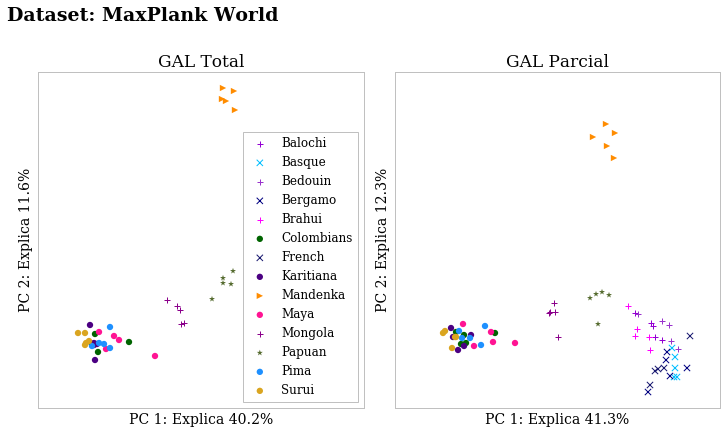

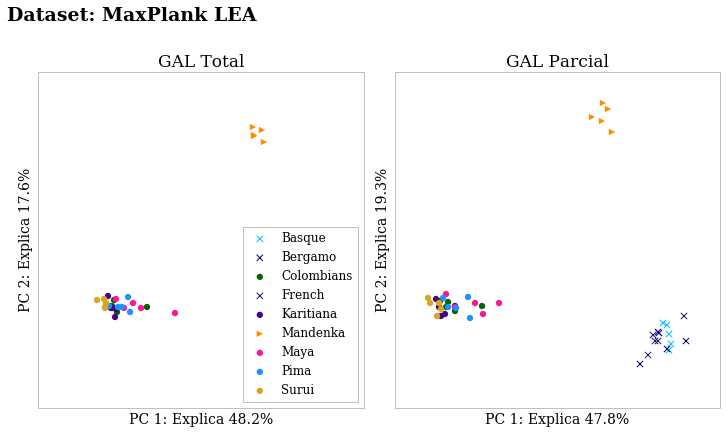

In [79]:
% run plot_PCAs.py

hgdp_panel_name = "MaxPlank"

panel_indices = OrderedDict()
panel_indices['GAL Total'] = galanter.index
panel_indices['GAL Parcial'] = present.index

for dataset_label, dataset in datasets_mplank.items():
    pca = plot_PCAs(dataset_label, panel_indices, dataset,
                    mplank_populations, plot_markers, plot_colors)